# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 19849083.30it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 614870.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 5605822.01it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 8337211.71it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

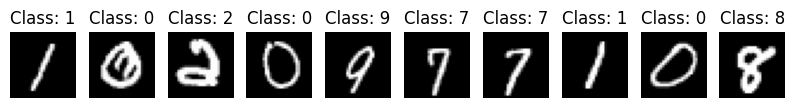

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="images/LinearModel_1.png"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5028143519560496, accuracy: 87.58541666666667
Epoch 0: val. loss: 0.49500534731022855, val. accuracy: 87.52499999999999
Epoch 1: training loss: 0.4220369331439336, accuracy: 88.99375
Epoch 1: val. loss: 0.4125511557497877, val. accuracy: 88.80833333333334
Epoch 2: training loss: 0.38797426176071165, accuracy: 89.65833333333333
Epoch 2: val. loss: 0.37789822829530595, val. accuracy: 89.46666666666667
Epoch 3: training loss: 0.3679744621515274, accuracy: 90.08125
Epoch 3: val. loss: 0.3577214614190954, val. accuracy: 89.875
Epoch 4: training loss: 0.3543776216506958, accuracy: 90.39375
Epoch 4: val. loss: 0.3441430807430693, val. accuracy: 90.21666666666667
CPU times: user 1min 9s, sys: 186 ms, total: 1min 9s
Wall time: 1min 9s


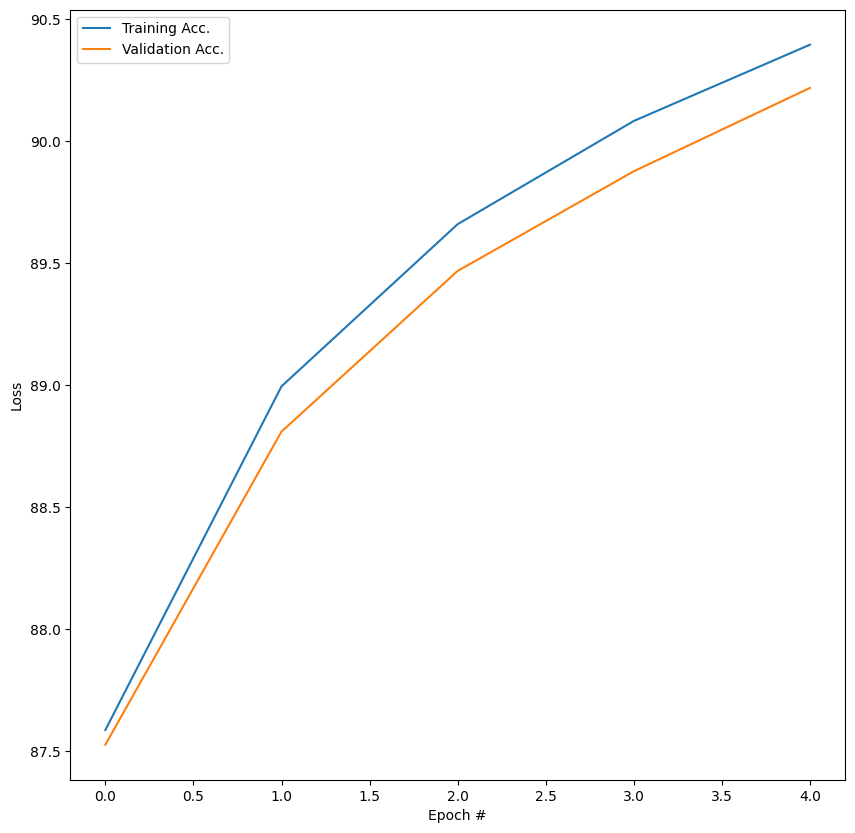

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

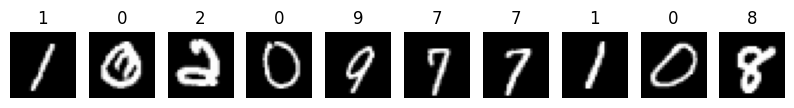

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3325, test accuracy: 90.80%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


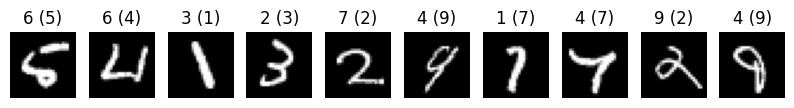

In [182]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [27]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.9115958533287049, accuracy: 74.73958333333334
Epoch 0: val. loss: 0.90133088446678, val. accuracy: 74.26666666666667
Epoch 1: training loss: 0.403128494143486, accuracy: 88.73333333333333
Epoch 1: val. loss: 0.39315388843100124, val. accuracy: 88.725
Epoch 2: training loss: 0.3152273001670837, accuracy: 91.14791666666666
Epoch 2: val. loss: 0.30510543286800385, val. accuracy: 90.88333333333334
Epoch 3: training loss: 0.25097400951385496, accuracy: 92.88541666666667
Epoch 3: val. loss: 0.24519885157017, val. accuracy: 92.76666666666667
Epoch 4: training loss: 0.20956620717048646, accuracy: 94.15208333333334
Epoch 4: val. loss: 0.20779135268419346, val. accuracy: 93.95833333333333
CPU times: user 1min 23s, sys: 199 ms, total: 1min 24s
Wall time: 1min 31s


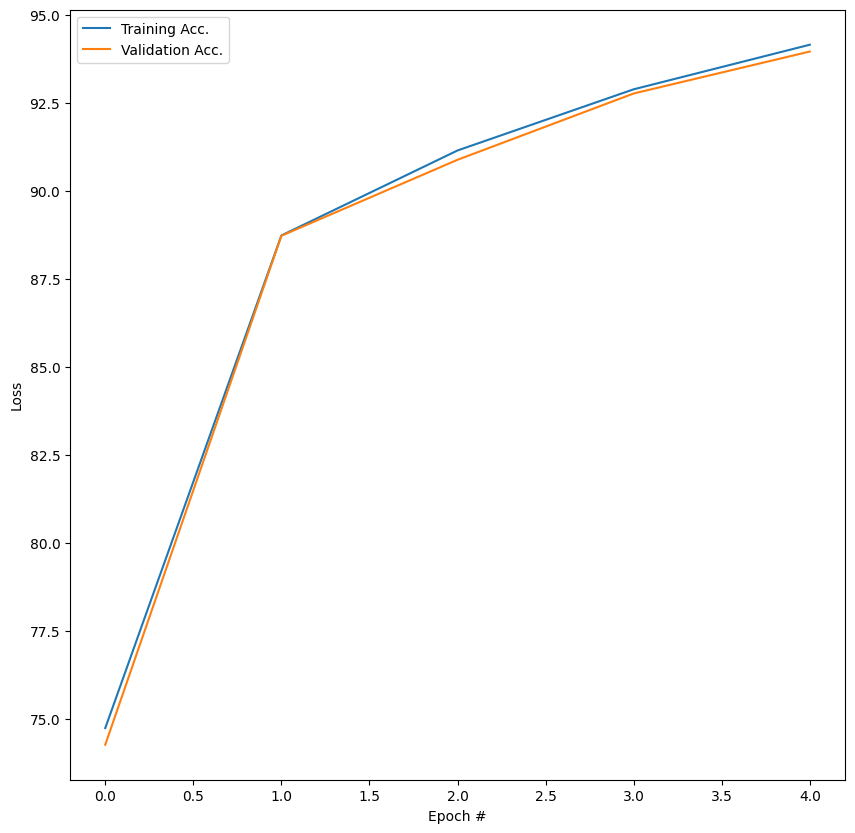

In [28]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


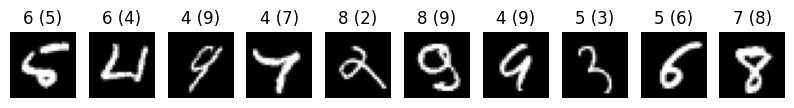

In [29]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

# Homework Starts

## Task 1: Compare Quality of models

### Testing different Batch Sizes

Original Batch size: 128

Tested Sizes: 32, 64, 256, 512

In [43]:
batch_size = 32
nonlinear_model1 = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model1.parameters(), lr=0.05)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [44]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model1, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model1, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model1, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2524357219735781, accuracy: 92.72916666666666
Epoch 0: val. loss: 0.24548032204806805, val. accuracy: 92.78333333333333
Epoch 1: training loss: 0.17943106023967267, accuracy: 94.6875
Epoch 1: val. loss: 0.18776146894196669, val. accuracy: 94.43333333333334
Epoch 2: training loss: 0.14683812128348897, accuracy: 95.60833333333333
Epoch 2: val. loss: 0.15928533225506544, val. accuracy: 95.15833333333333
Epoch 3: training loss: 0.11982574951726323, accuracy: 96.40833333333333
Epoch 3: val. loss: 0.14034507742275795, val. accuracy: 95.8
Epoch 4: training loss: 0.10478472751673931, accuracy: 96.89791666666666
Epoch 4: val. loss: 0.12996575733522575, val. accuracy: 96.15833333333333
CPU times: user 1min 23s, sys: 182 ms, total: 1min 24s
Wall time: 1min 24s


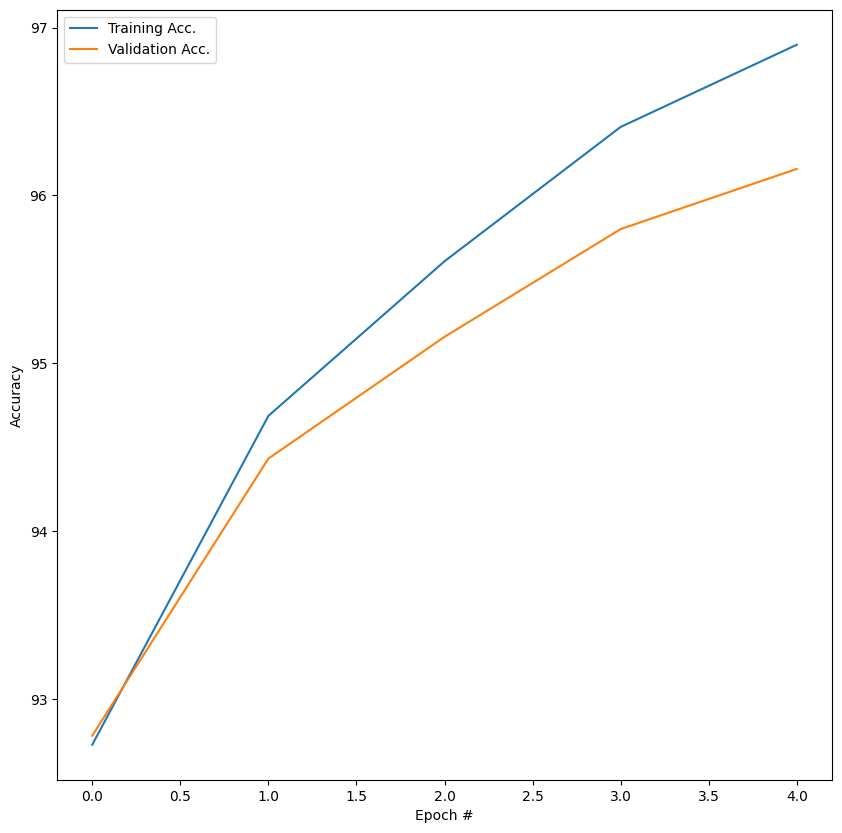

In [45]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

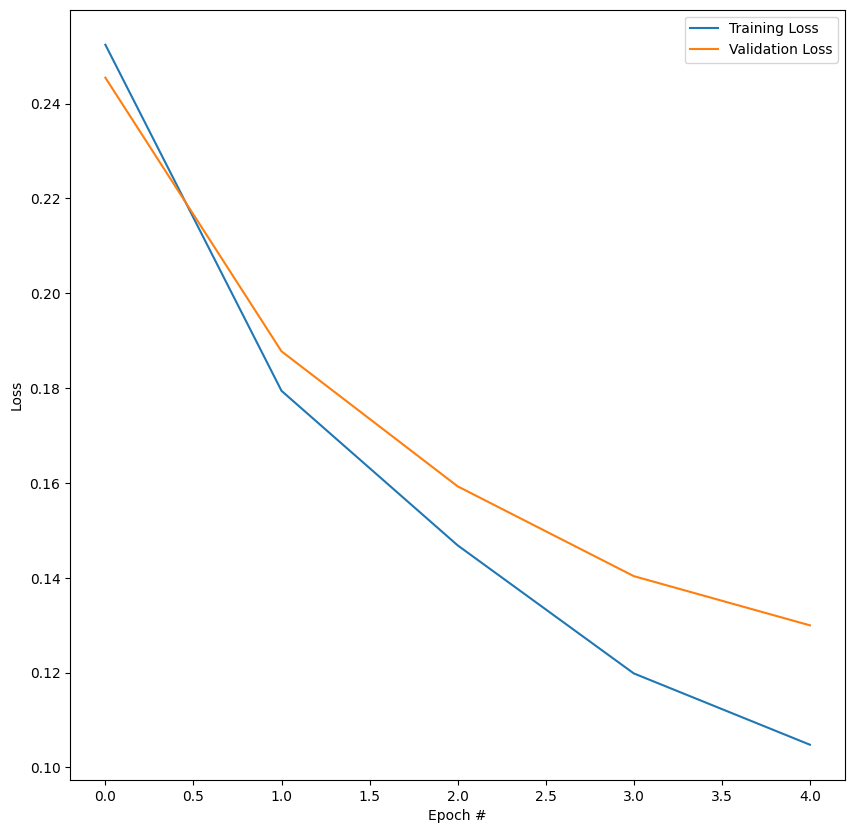

In [46]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [47]:
batch_size = 64
nonlinear_model2 = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model2.parameters(), lr=0.05)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [48]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model2, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model2, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model2, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.4086763195991516, accuracy: 88.24791666666667
Epoch 0: val. loss: 0.40138287192329447, val. accuracy: 88.3
Epoch 1: training loss: 0.25184197929501534, accuracy: 92.61458333333333
Epoch 1: val. loss: 0.2509099142031467, val. accuracy: 92.33333333333333
Epoch 2: training loss: 0.18415370493630567, accuracy: 94.68124999999999
Epoch 2: val. loss: 0.1893269820138812, val. accuracy: 94.31666666666668
Epoch 3: training loss: 0.14966651284197965, accuracy: 95.66041666666666
Epoch 3: val. loss: 0.16006971885787047, val. accuracy: 95.025
Epoch 4: training loss: 0.13608200665314993, accuracy: 96.12916666666666
Epoch 4: val. loss: 0.15247032020558068, val. accuracy: 95.33333333333334
CPU times: user 1min 15s, sys: 171 ms, total: 1min 16s
Wall time: 1min 16s


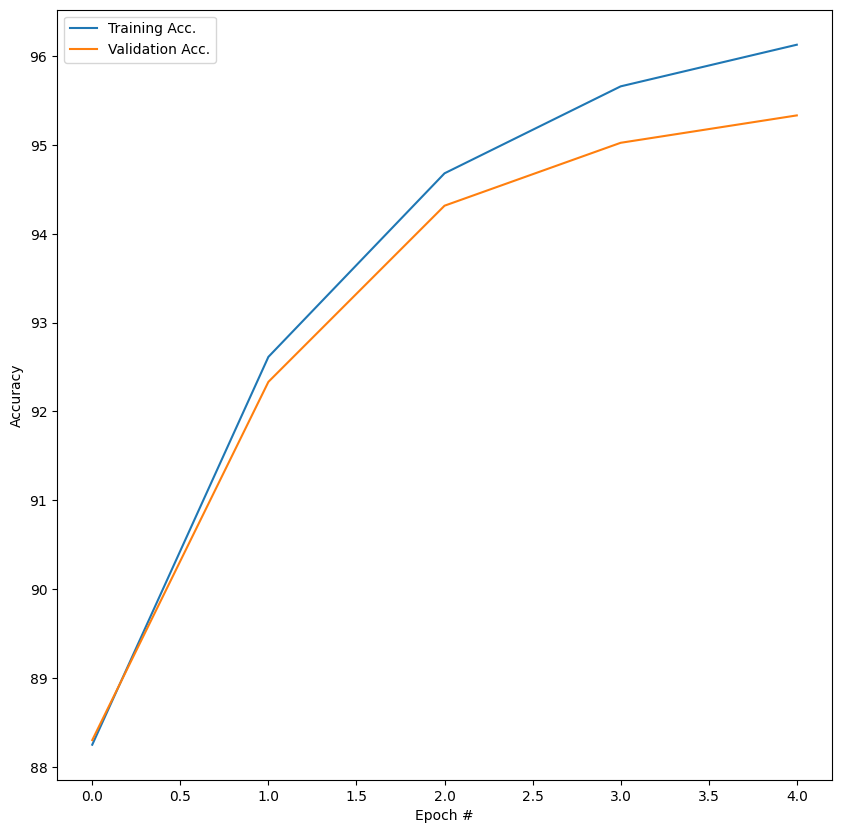

In [49]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

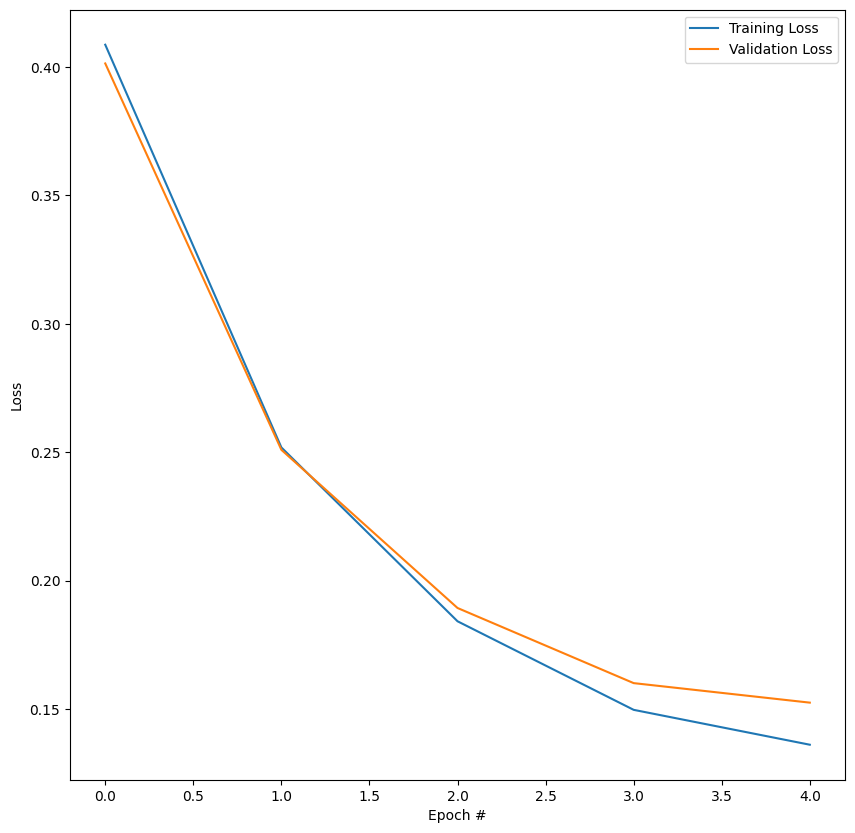

In [50]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [51]:
batch_size = 256
nonlinear_model3 = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model3.parameters(), lr=0.05)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [52]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model3, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model3, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model3, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.0556262477915337, accuracy: 37.12916666666667
Epoch 0: val. loss: 2.053727515200351, val. accuracy: 37.641666666666666
Epoch 1: training loss: 0.7712379998349129, accuracy: 77.29583333333333
Epoch 1: val. loss: 0.7676960572283319, val. accuracy: 77.025
Epoch 2: training loss: 0.48586828562807527, accuracy: 85.96041666666666
Epoch 2: val. loss: 0.48152575023630834, val. accuracy: 86.08333333333333
Epoch 3: training loss: 0.3915621798406256, accuracy: 88.84583333333333
Epoch 3: val. loss: 0.38577562253525916, val. accuracy: 88.775
Epoch 4: training loss: 0.33637363867873843, accuracy: 90.33125
Epoch 4: val. loss: 0.329632449657359, val. accuracy: 90.24166666666666
CPU times: user 1min 9s, sys: 152 ms, total: 1min 9s
Wall time: 1min 10s


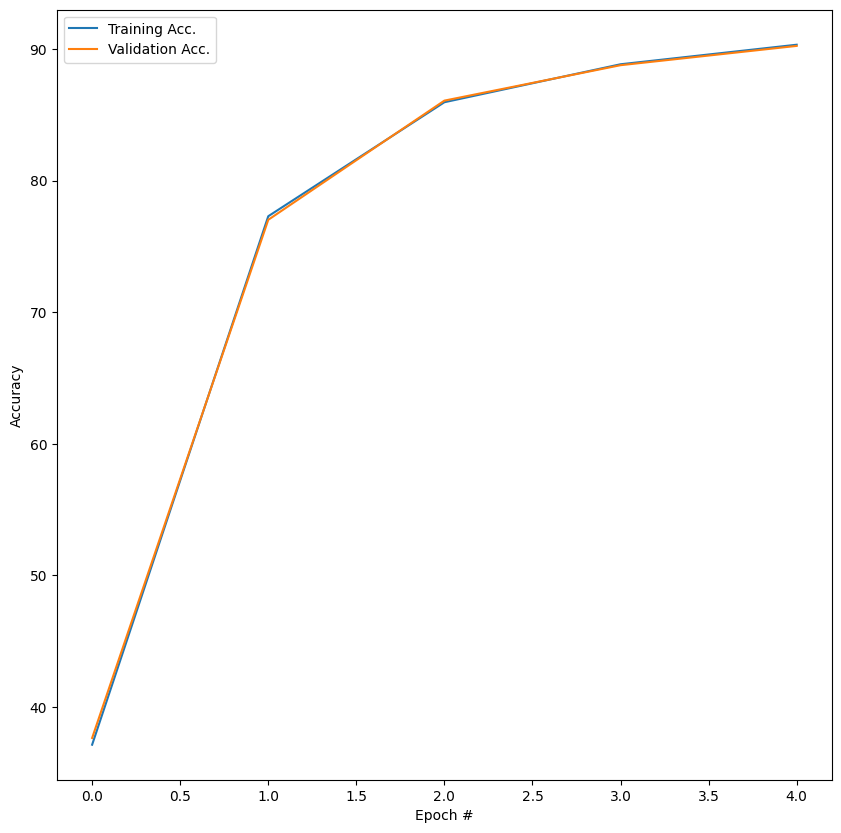

In [53]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

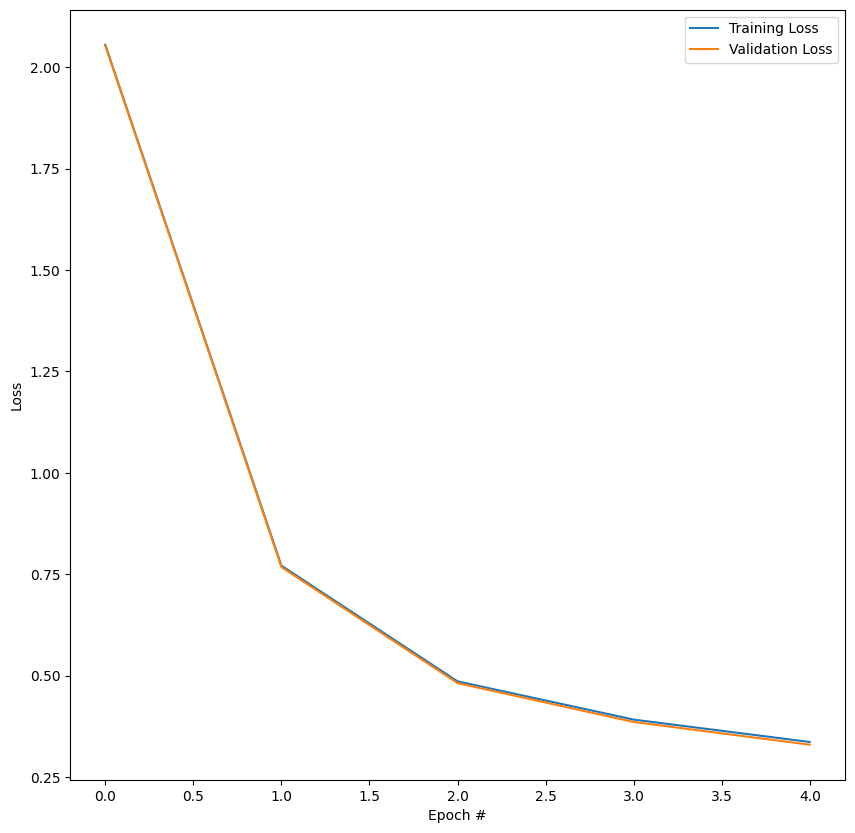

In [54]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [55]:
batch_size = 512
nonlinear_model4 = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model4.parameters(), lr=0.05)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [56]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model4, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model4, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model4, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.259611502606818, accuracy: 24.06875
Epoch 0: val. loss: 2.2590737839539847, val. accuracy: 24.775
Epoch 1: training loss: 1.9256029230483034, accuracy: 39.31875
Epoch 1: val. loss: 1.919772023955981, val. accuracy: 39.36666666666667
Epoch 2: training loss: 1.2196960056081732, accuracy: 64.26666666666667
Epoch 2: val. loss: 1.2154485434293747, val. accuracy: 64.34166666666667
Epoch 3: training loss: 0.7732366038129684, accuracy: 78.88958333333333
Epoch 3: val. loss: 0.7721962556242943, val. accuracy: 78.39166666666667
Epoch 4: training loss: 0.5654323633680952, accuracy: 84.03541666666666
Epoch 4: val. loss: 0.5622494195898374, val. accuracy: 83.80833333333332
CPU times: user 1min 8s, sys: 158 ms, total: 1min 8s
Wall time: 1min 8s


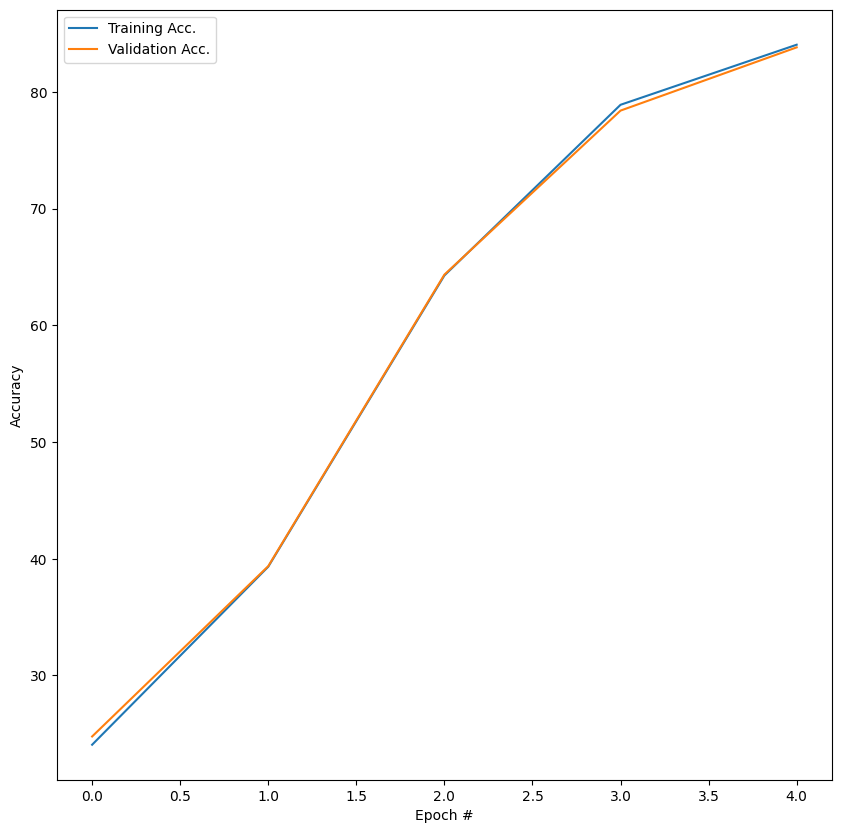

In [57]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

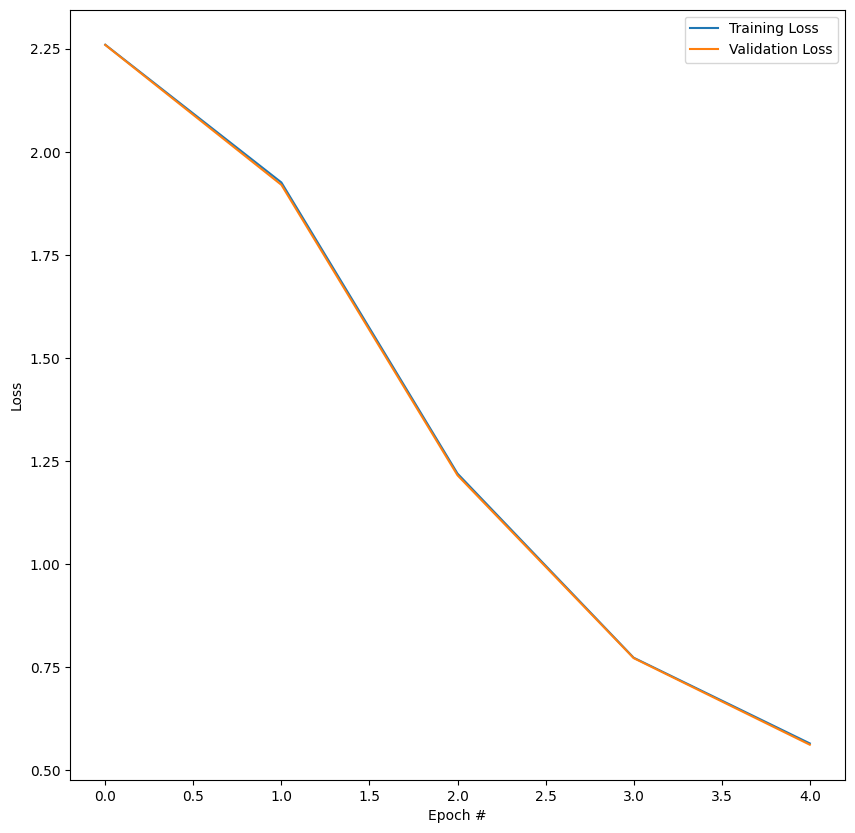

In [58]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Based on the experiments, the best performance of the model is achieved using batch size of 32 and 64. However, we observe that the val.loss and accuracy start to diverge from the training loss and accuracy insignificantly (i.e., 1-3%) which may be an indicator or possible overfitting. While training with batch size of 256 results in the lower accuracy then 32, 64, and 128, the acc. and loss curves are more stable.

Next, we will investigate the effect of different learning rates. We will perform learning rates testing for batch size training of 32, 64, and 256

### Testing different Learning Rates



Original Batch size: 0.05

Tested Sizes: 0.001, 0.005, 0.01, 0.1


First, we test with batch size of 32

In [59]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.001)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [62]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.299871454079946, accuracy: 9.768749999999999
Epoch 0: val. loss: 2.300859353383382, val. accuracy: 9.625
Epoch 1: training loss: 2.2987710369428, accuracy: 9.770833333333332
Epoch 1: val. loss: 2.2997248713175455, val. accuracy: 9.625
Epoch 2: training loss: 2.2976744322776796, accuracy: 9.80625
Epoch 2: val. loss: 2.298595978418986, val. accuracy: 9.641666666666666
Epoch 3: training loss: 2.2965699496269227, accuracy: 9.9125
Epoch 3: val. loss: 2.297461086908976, val. accuracy: 9.791666666666666
Epoch 4: training loss: 2.295461133480072, accuracy: 10.137500000000001
Epoch 4: val. loss: 2.2963241850535074, val. accuracy: 10.125
CPU times: user 1min 41s, sys: 259 ms, total: 1min 41s
Wall time: 2min 5s


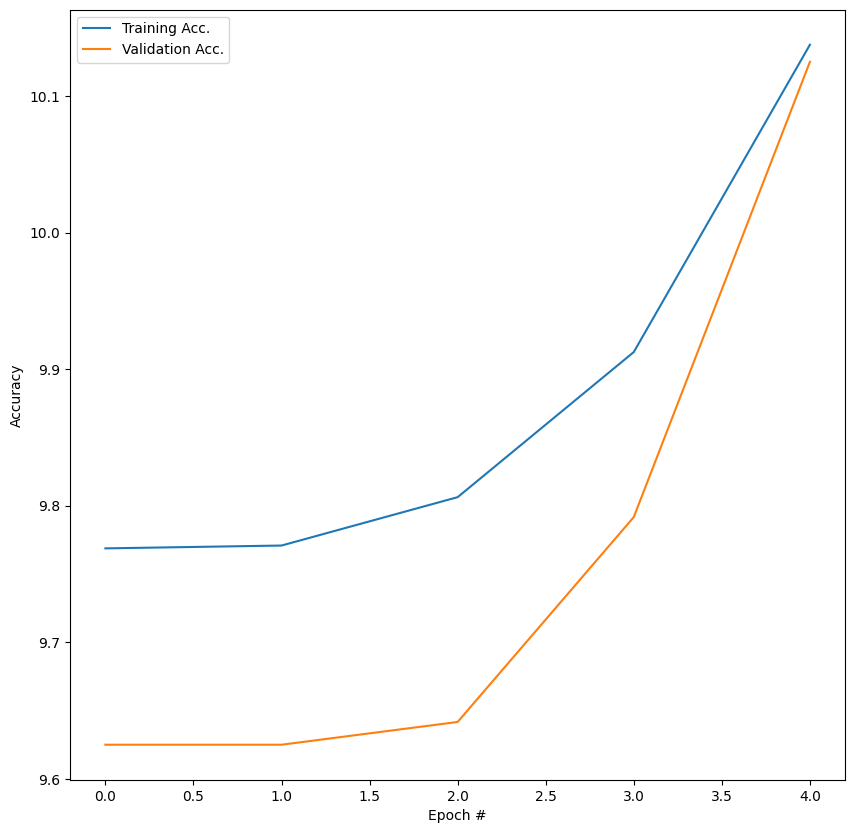

In [63]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

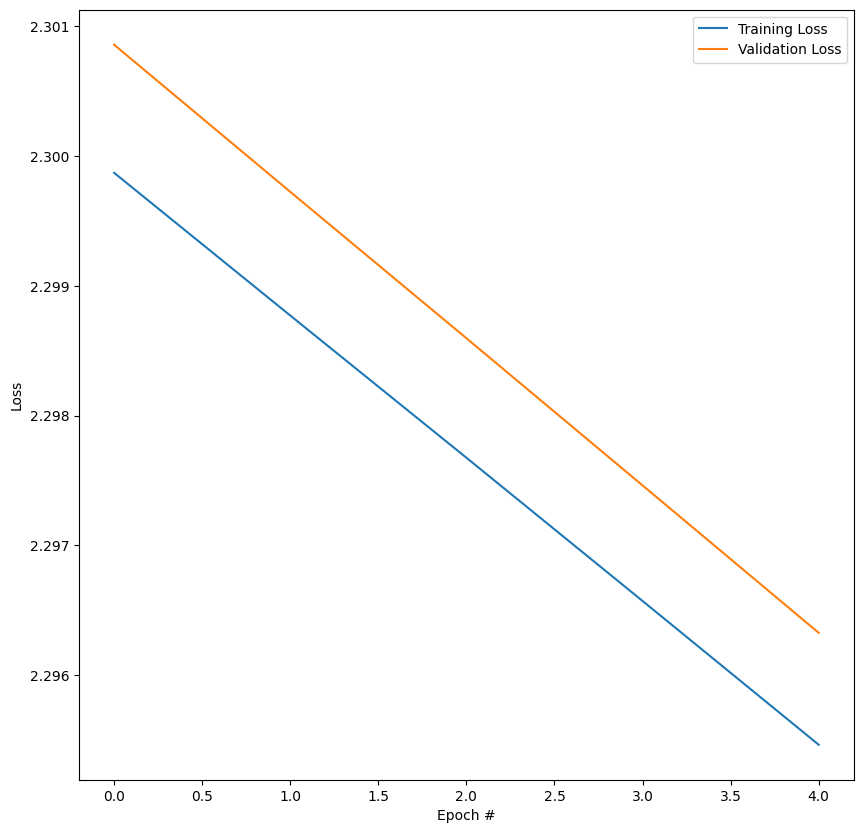

In [64]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [65]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.005)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [66]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.1135371644496916, accuracy: 32.208333333333336
Epoch 0: val. loss: 2.1123494046529134, val. accuracy: 32.44166666666667
Epoch 1: training loss: 0.9284794817765554, accuracy: 72.1875
Epoch 1: val. loss: 0.9215800015131632, val. accuracy: 72.26666666666667
Epoch 2: training loss: 0.5790914012690385, accuracy: 83.70208333333333
Epoch 2: val. loss: 0.5704471737146377, val. accuracy: 83.48333333333333
Epoch 3: training loss: 0.4453551448583603, accuracy: 87.37083333333334
Epoch 3: val. loss: 0.4364858713944753, val. accuracy: 87.53333333333333
Epoch 4: training loss: 0.38204534189403055, accuracy: 89.28333333333333
Epoch 4: val. loss: 0.3716052910486857, val. accuracy: 89.35833333333333
CPU times: user 1min 36s, sys: 227 ms, total: 1min 36s
Wall time: 1min 43s


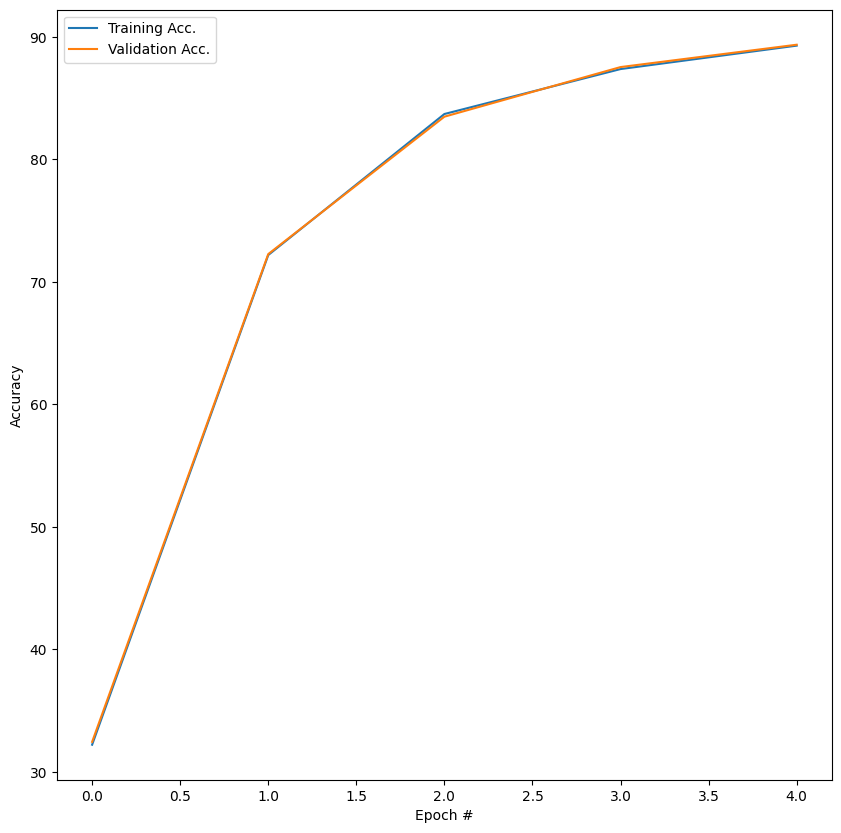

In [67]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

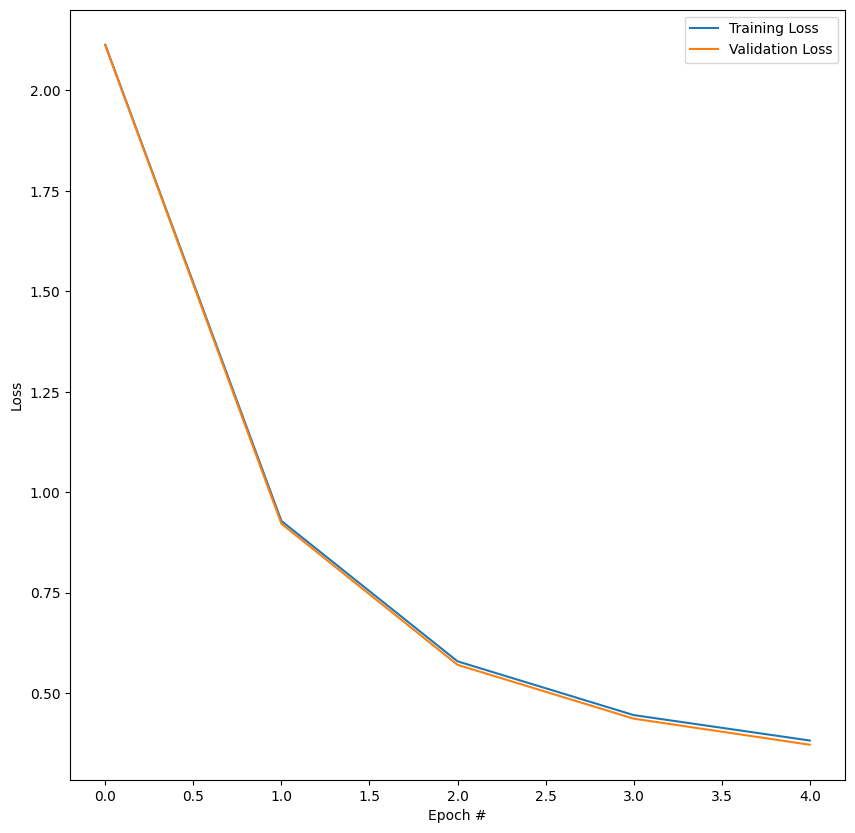

In [68]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [69]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [70]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 1.0400923171838126, accuracy: 76.80833333333334
Epoch 0: val. loss: 1.0312826590538025, val. accuracy: 76.64999999999999
Epoch 1: training loss: 0.43644827546676, accuracy: 87.64375
Epoch 1: val. loss: 0.42932039467493693, val. accuracy: 87.69166666666666
Epoch 2: training loss: 0.3369154459809264, accuracy: 90.48125
Epoch 2: val. loss: 0.3293347129027049, val. accuracy: 90.20833333333333
Epoch 3: training loss: 0.28200823865582547, accuracy: 92.00625
Epoch 3: val. loss: 0.276533255358537, val. accuracy: 91.66666666666666
Epoch 4: training loss: 0.23968794538949928, accuracy: 93.13541666666667
Epoch 4: val. loss: 0.2372942002514998, val. accuracy: 92.80000000000001
CPU times: user 1min 22s, sys: 197 ms, total: 1min 22s
Wall time: 1min 23s


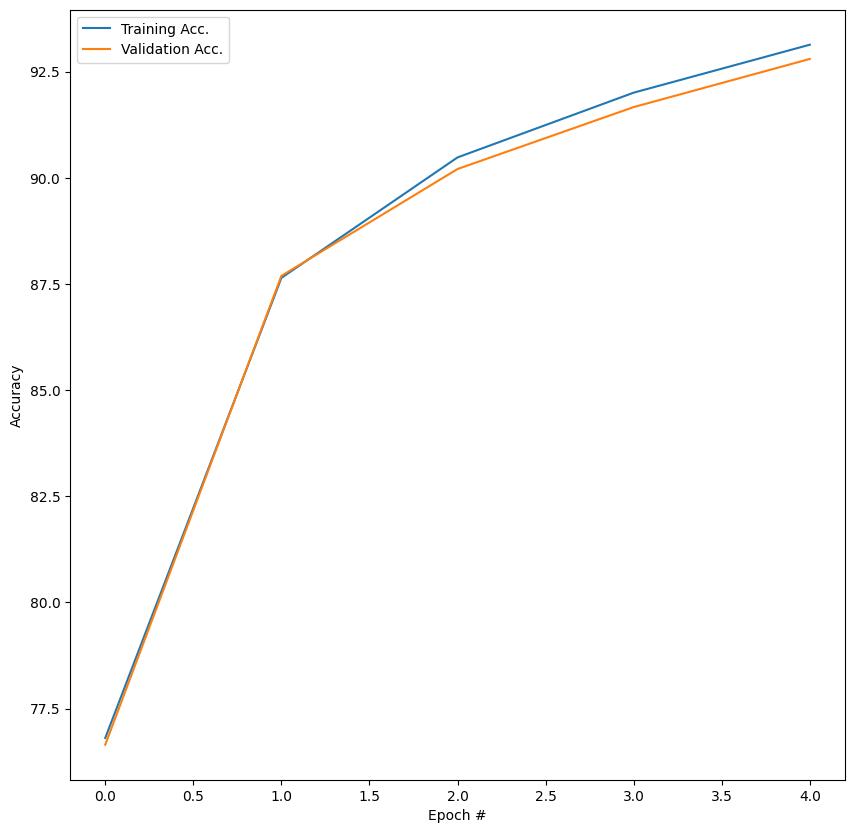

In [71]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

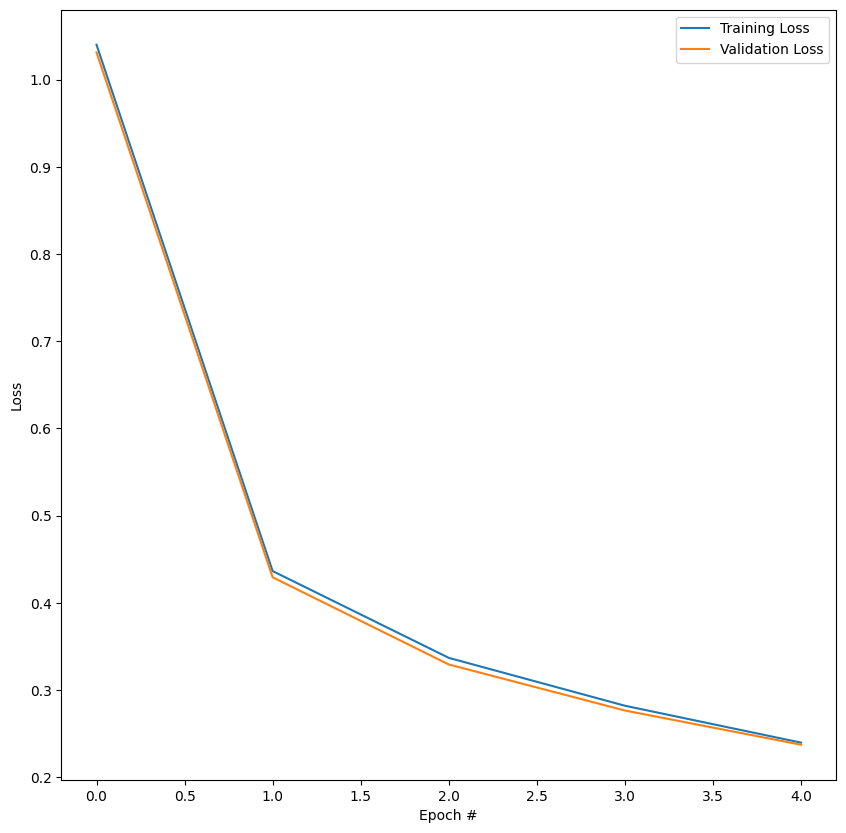

In [72]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [73]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [74]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.1966742779656003, accuracy: 94.08958333333334
Epoch 0: val. loss: 0.19695678326239188, val. accuracy: 94.30833333333334
Epoch 1: training loss: 0.1474534135942037, accuracy: 95.40833333333333
Epoch 1: val. loss: 0.15549634925524394, val. accuracy: 95.25833333333334
Epoch 2: training loss: 0.12163097393652424, accuracy: 96.33749999999999
Epoch 2: val. loss: 0.1386989544344445, val. accuracy: 95.75833333333334
Epoch 3: training loss: 0.1045602855909771, accuracy: 96.75833333333334
Epoch 3: val. loss: 0.11757349299639464, val. accuracy: 96.41666666666666
Epoch 4: training loss: 0.10057915502126949, accuracy: 96.89166666666667
Epoch 4: val. loss: 0.11510983261248718, val. accuracy: 96.51666666666667
CPU times: user 1min 22s, sys: 176 ms, total: 1min 22s
Wall time: 1min 23s


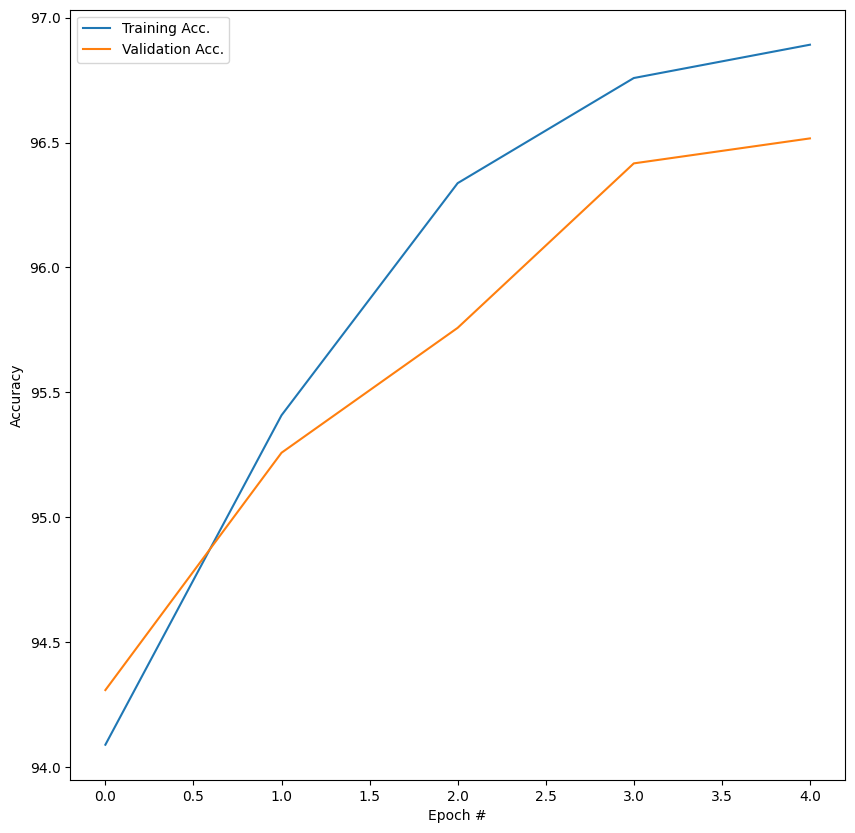

In [75]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

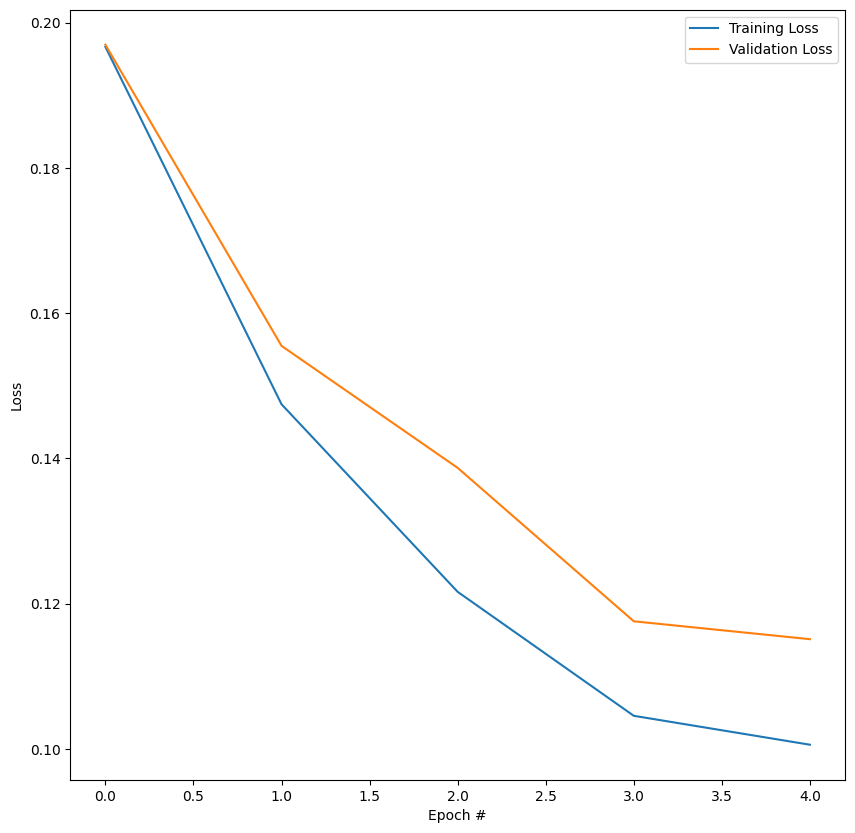

In [76]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Next, we train with batch size of 64

In [77]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.001)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [78]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.304856644630432, accuracy: 9.518749999999999
Epoch 0: val. loss: 2.3051621444681856, val. accuracy: 8.674999999999999
Epoch 1: training loss: 2.3016793829600015, accuracy: 9.325
Epoch 1: val. loss: 2.301924591368817, val. accuracy: 8.816666666666666
Epoch 2: training loss: 2.2985413802464802, accuracy: 9.629166666666666
Epoch 2: val. loss: 2.298736538024659, val. accuracy: 9.341666666666667
Epoch 3: training loss: 2.295188131014506, accuracy: 10.89375
Epoch 3: val. loss: 2.2953421739821738, val. accuracy: 10.691666666666666
Epoch 4: training loss: 2.2913225844701133, accuracy: 14.670833333333333
Epoch 4: val. loss: 2.291452907501383, val. accuracy: 14.816666666666666
CPU times: user 1min 15s, sys: 184 ms, total: 1min 15s
Wall time: 1min 16s


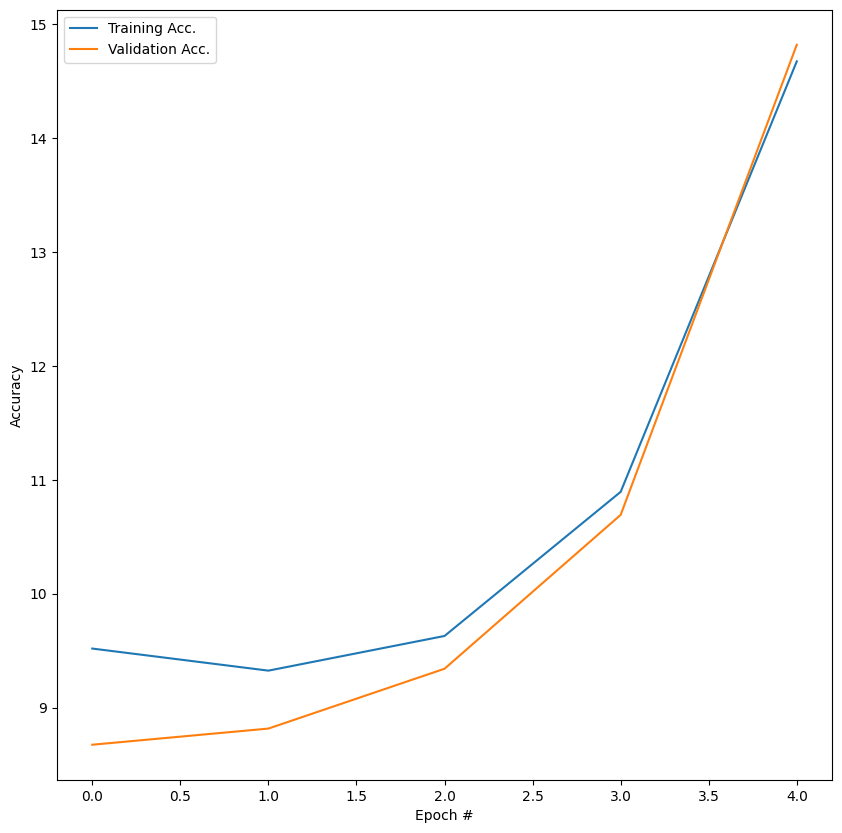

In [79]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

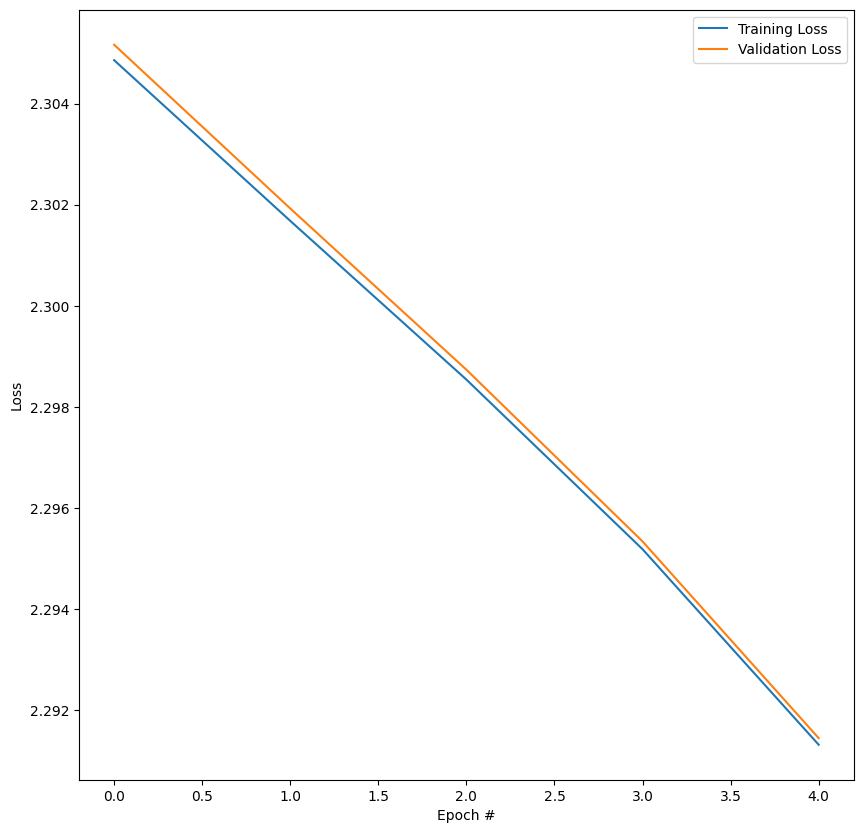

In [80]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [81]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.005)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [82]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.2693674739201866, accuracy: 20.954166666666666
Epoch 0: val. loss: 2.268580900861862, val. accuracy: 21.141666666666666
Epoch 1: training loss: 2.0983412971496582, accuracy: 46.86458333333333
Epoch 1: val. loss: 2.097288178636673, val. accuracy: 47.11666666666667
Epoch 2: training loss: 1.381960105419159, accuracy: 56.69791666666667
Epoch 2: val. loss: 1.3753350205877994, val. accuracy: 57.074999999999996
Epoch 3: training loss: 0.9139262149333954, accuracy: 72.38541666666667
Epoch 3: val. loss: 0.9100551554497253, val. accuracy: 72.35833333333333
Epoch 4: training loss: 0.670027983546257, accuracy: 81.66041666666666
Epoch 4: val. loss: 0.665981040197484, val. accuracy: 81.26666666666667
CPU times: user 1min 15s, sys: 158 ms, total: 1min 15s
Wall time: 1min 16s


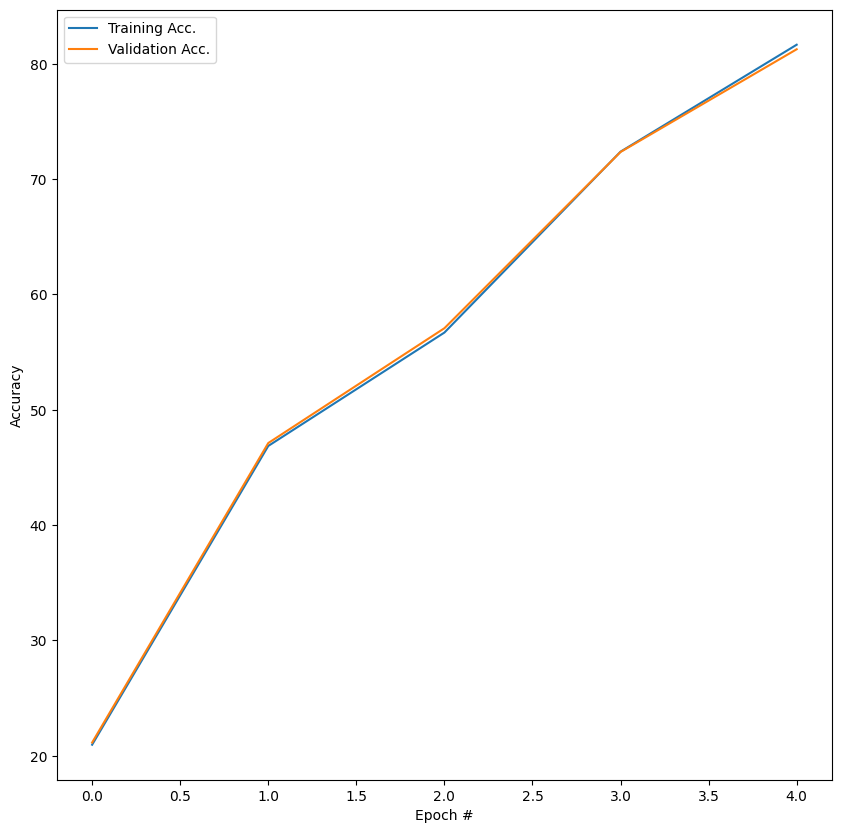

In [83]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

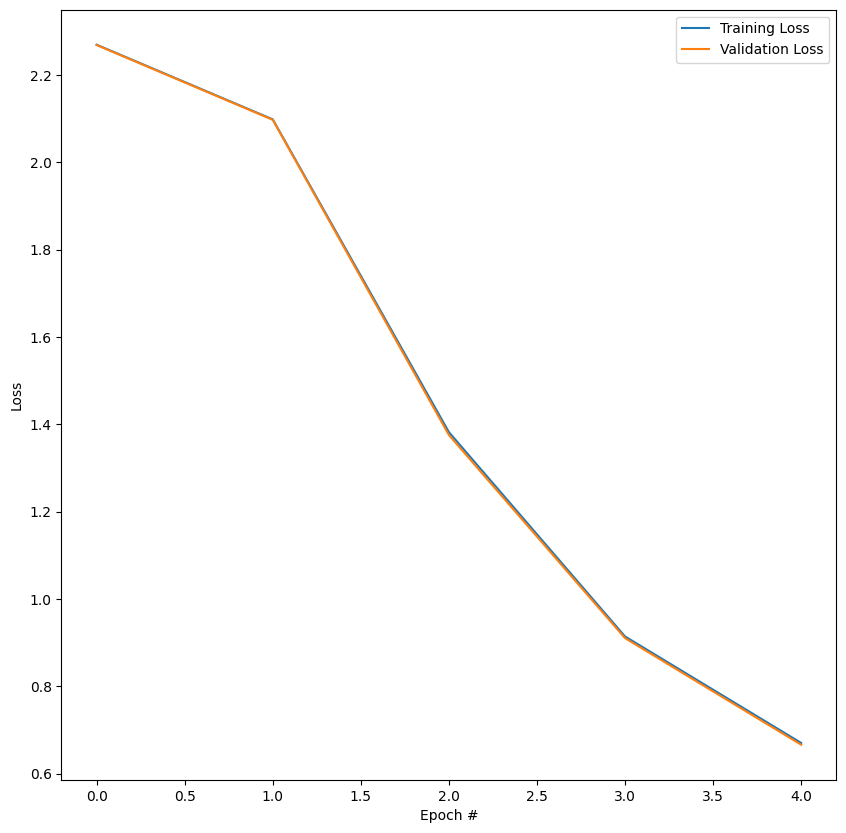

In [84]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [85]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [86]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.226169802347819, accuracy: 39.954166666666666
Epoch 0: val. loss: 2.2257479264381086, val. accuracy: 40.108333333333334
Epoch 1: training loss: 1.159294101715088, accuracy: 68.76875
Epoch 1: val. loss: 1.1545229563687711, val. accuracy: 69.41666666666667
Epoch 2: training loss: 0.6214077552954356, accuracy: 81.78541666666666
Epoch 2: val. loss: 0.6146641987118315, val. accuracy: 81.61666666666667
Epoch 3: training loss: 0.4770593814452489, accuracy: 86.48541666666667
Epoch 3: val. loss: 0.47045219634124574, val. accuracy: 86.28333333333333
Epoch 4: training loss: 0.4055413861870766, accuracy: 88.52291666666666
Epoch 4: val. loss: 0.3990804415909534, val. accuracy: 88.3
CPU times: user 1min 16s, sys: 179 ms, total: 1min 17s
Wall time: 1min 17s


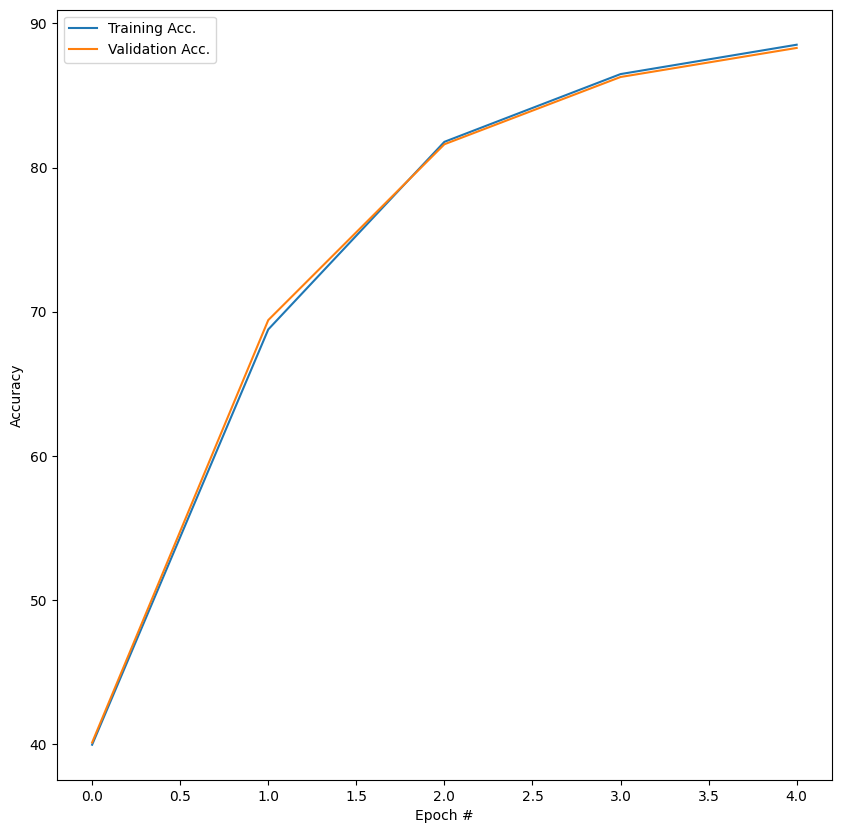

In [87]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

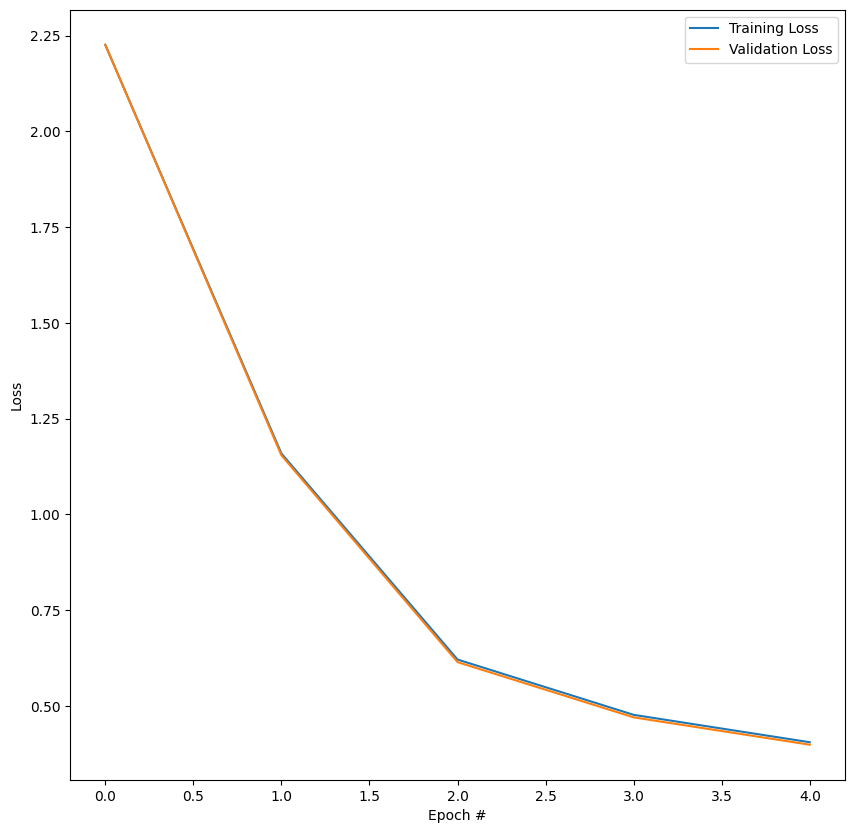

In [88]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [89]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [90]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.31003200486302374, accuracy: 90.825
Epoch 0: val. loss: 0.30009871142658784, val. accuracy: 90.86666666666666
Epoch 1: training loss: 0.18413669058680535, accuracy: 94.64583333333333
Epoch 1: val. loss: 0.1878992454842367, val. accuracy: 94.45833333333333
Epoch 2: training loss: 0.14073408761868875, accuracy: 95.85625
Epoch 2: val. loss: 0.14805985975297206, val. accuracy: 95.61666666666667
Epoch 3: training loss: 0.12316080208619436, accuracy: 96.35833333333333
Epoch 3: val. loss: 0.1332604170955242, val. accuracy: 95.98333333333333
Epoch 4: training loss: 0.09977966254825393, accuracy: 97.07916666666667
Epoch 4: val. loss: 0.11615192344749069, val. accuracy: 96.35000000000001
CPU times: user 1min 15s, sys: 147 ms, total: 1min 15s
Wall time: 1min 16s


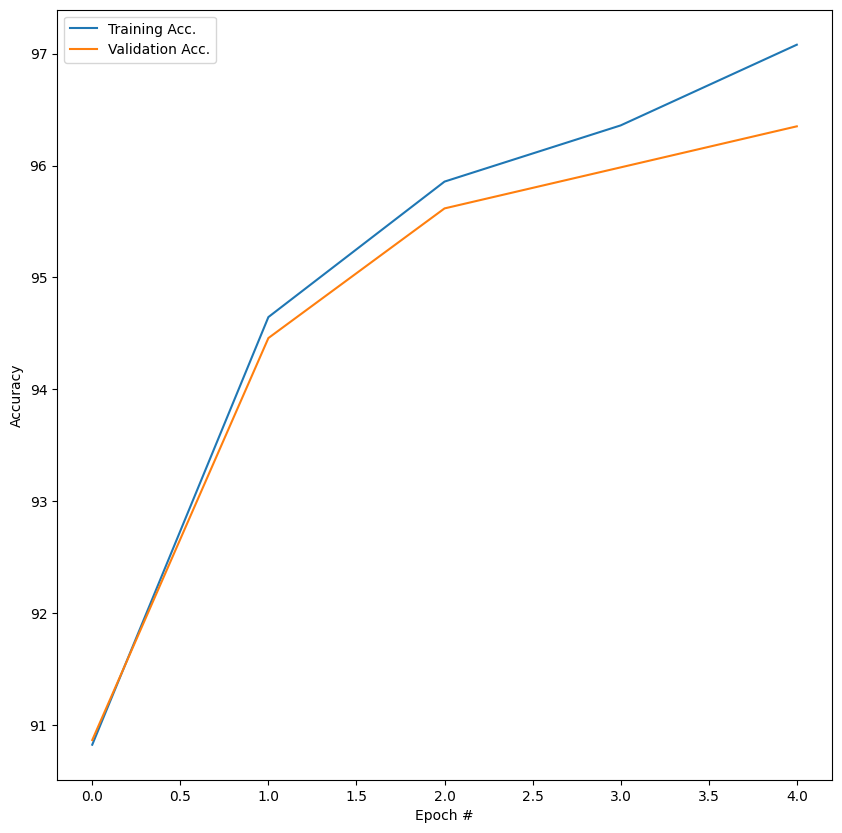

In [91]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

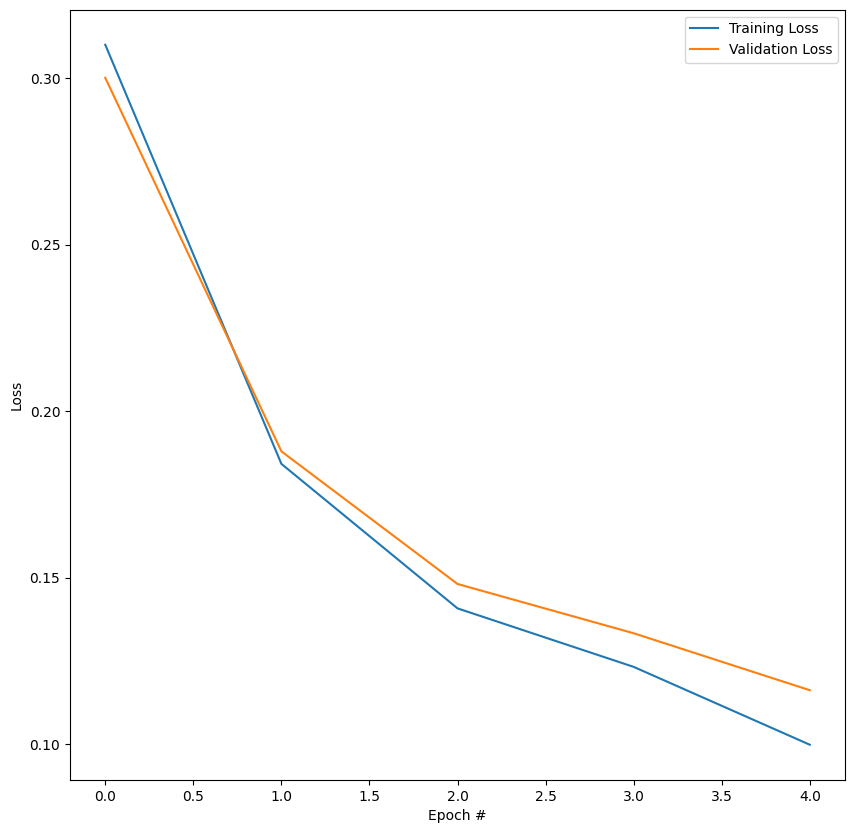

In [92]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

FInally, we train with batch size of 256

In [93]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.001)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [94]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.3033745758076933, accuracy: 13.402083333333334
Epoch 0: val. loss: 2.303186888390399, val. accuracy: 13.833333333333334
Epoch 1: training loss: 2.3020676995845553, accuracy: 14.091666666666667
Epoch 1: val. loss: 2.301857593211722, val. accuracy: 14.608333333333334
Epoch 2: training loss: 2.30076069527484, accuracy: 14.9625
Epoch 2: val. loss: 2.300526806648741, val. accuracy: 15.391666666666667
Epoch 3: training loss: 2.2994458802202913, accuracy: 15.772916666666667
Epoch 3: val. loss: 2.2991871225072984, val. accuracy: 16.225
Epoch 4: training loss: 2.2981037903339305, accuracy: 16.608333333333334
Epoch 4: val. loss: 2.29782069490311, val. accuracy: 17.091666666666665
CPU times: user 1min 8s, sys: 152 ms, total: 1min 9s
Wall time: 1min 9s


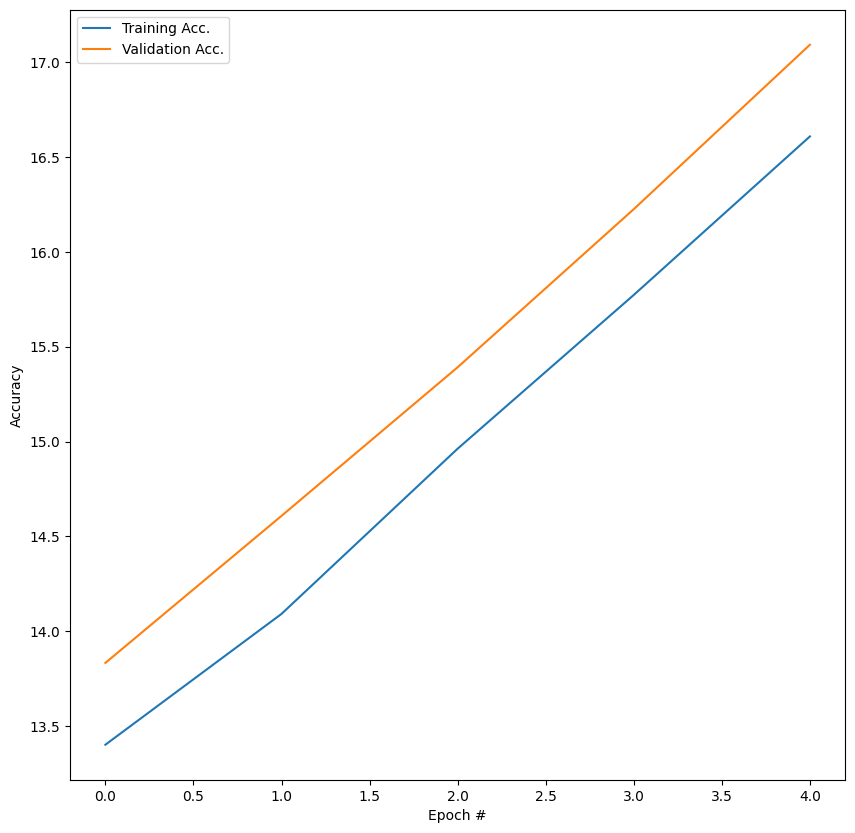

In [95]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

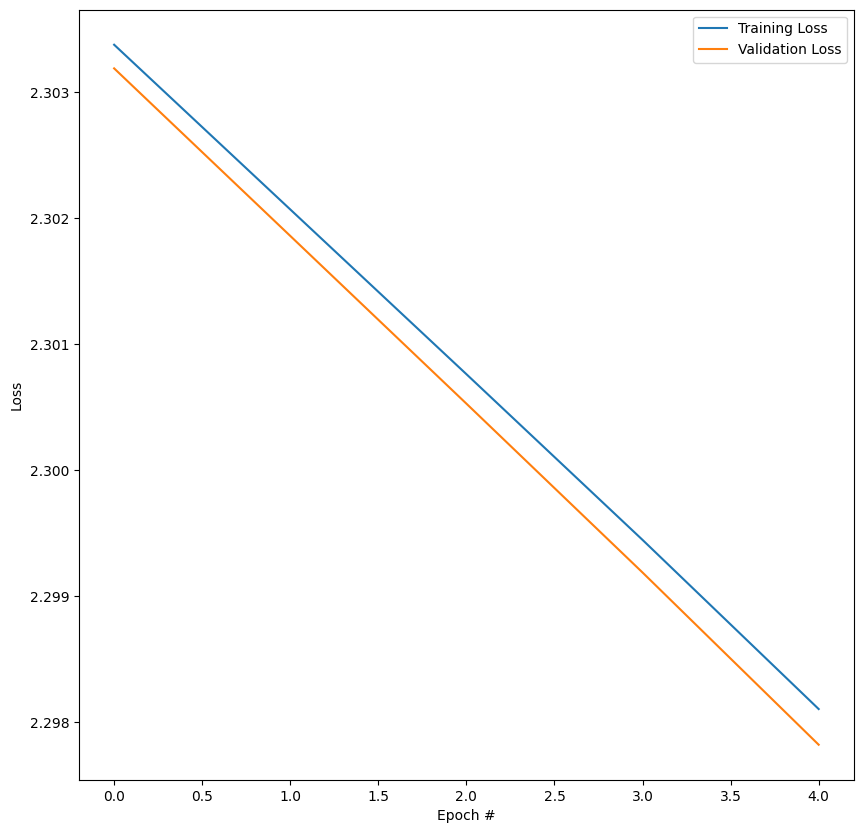

In [96]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [97]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.005)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [98]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.3026095413147134, accuracy: 10.472916666666666
Epoch 0: val. loss: 2.3017100780568223, val. accuracy: 10.225
Epoch 1: training loss: 2.2978374298582684, accuracy: 11.222916666666666
Epoch 1: val. loss: 2.2969882386796017, val. accuracy: 11.125
Epoch 2: training loss: 2.2919403479454363, accuracy: 12.3375
Epoch 2: val. loss: 2.2911170594235686, val. accuracy: 12.35
Epoch 3: training loss: 2.284153348587929, accuracy: 17.635416666666668
Epoch 3: val. loss: 2.2833150244773703, val. accuracy: 18.0
Epoch 4: training loss: 2.2740089829931867, accuracy: 20.45625
Epoch 4: val. loss: 2.2730881406905805, val. accuracy: 20.641666666666666
CPU times: user 1min 8s, sys: 153 ms, total: 1min 8s
Wall time: 1min 9s


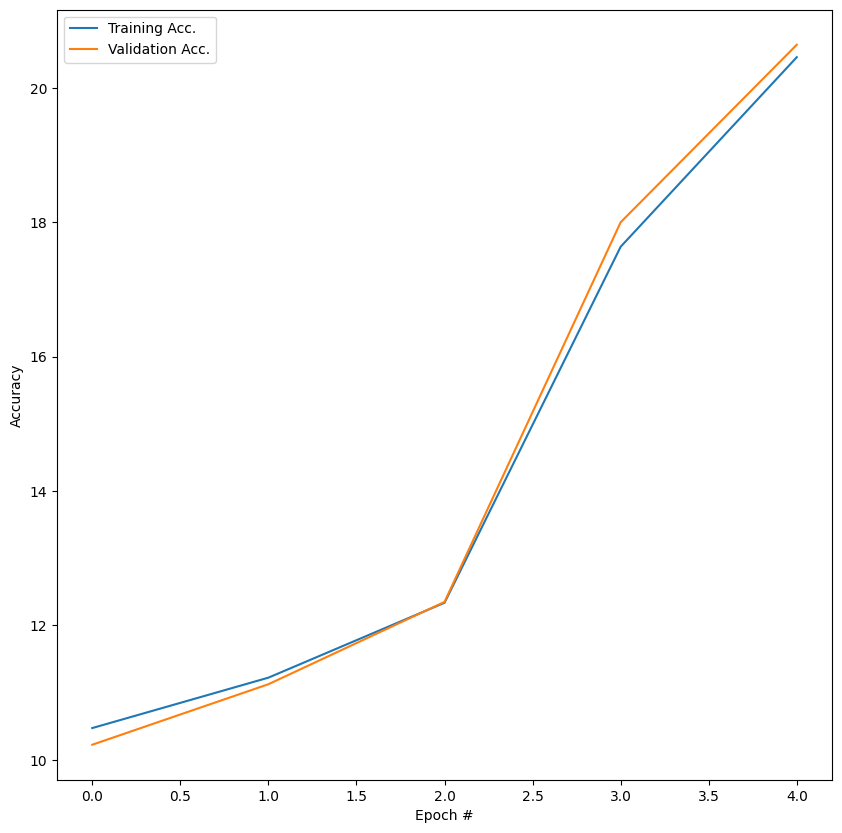

In [99]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

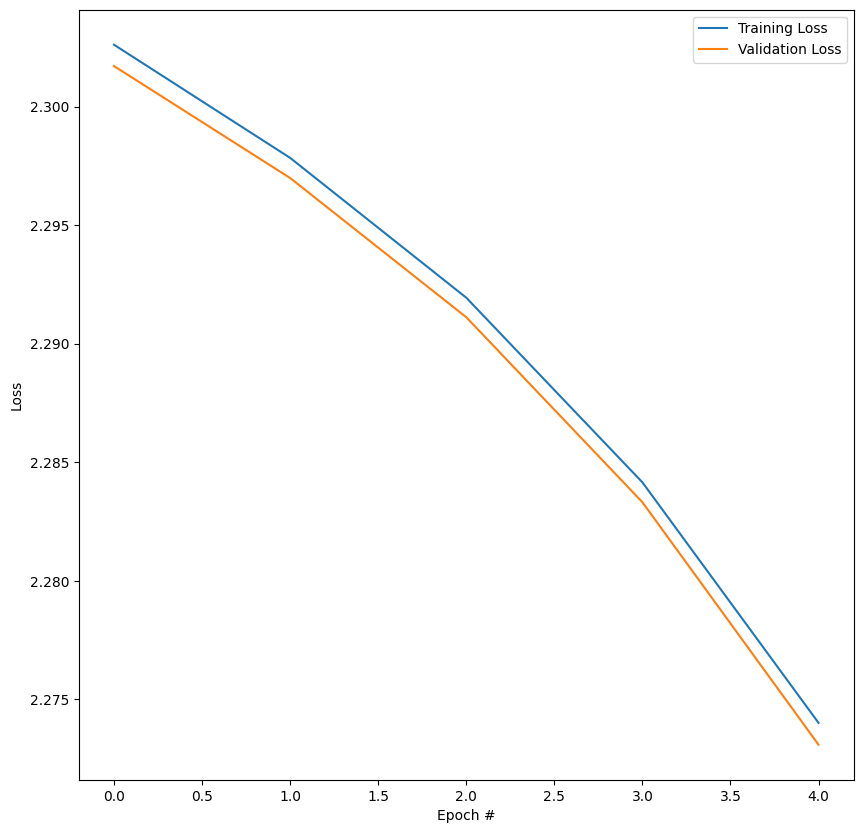

In [100]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [101]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [102]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.291905995379103, accuracy: 11.375
Epoch 0: val. loss: 2.2917670189066137, val. accuracy: 11.391666666666666
Epoch 1: training loss: 2.2702899080641727, accuracy: 26.450000000000003
Epoch 1: val. loss: 2.2697276916909725, val. accuracy: 27.175
Epoch 2: training loss: 2.2226353490606265, accuracy: 32.91458333333333
Epoch 2: val. loss: 2.221265564573572, val. accuracy: 33.00833333333333
Epoch 3: training loss: 2.1010872074898255, accuracy: 37.38333333333333
Epoch 3: val. loss: 2.098013091594615, val. accuracy: 37.94166666666667
Epoch 4: training loss: 1.861187922193649, accuracy: 41.32083333333333
Epoch 4: val. loss: 1.854396883477556, val. accuracy: 42.0
CPU times: user 1min 8s, sys: 171 ms, total: 1min 8s
Wall time: 1min 9s


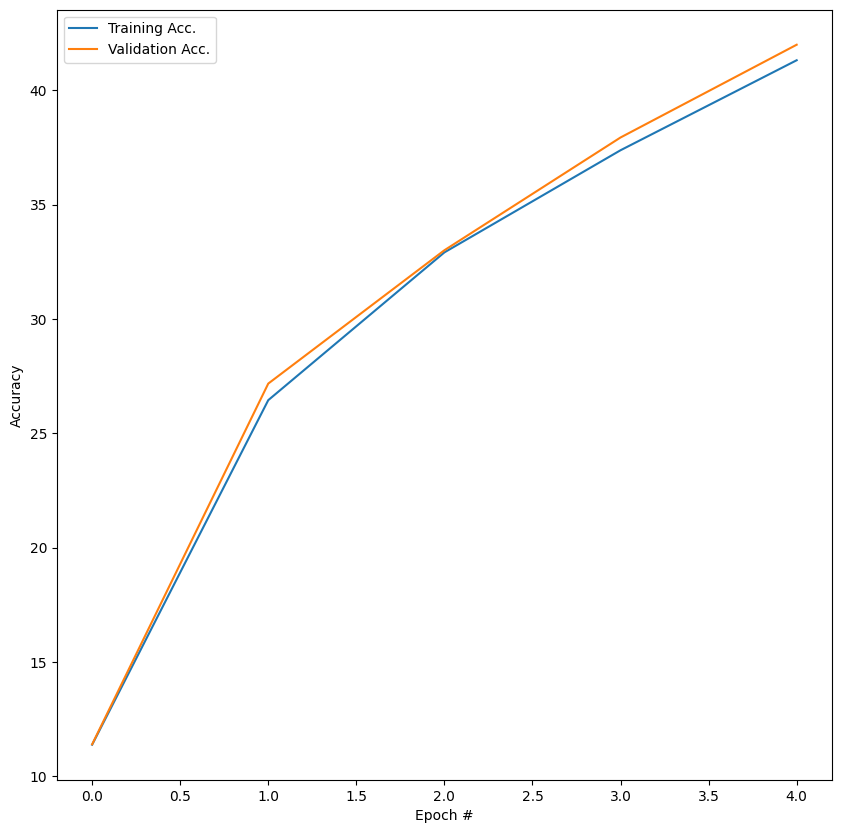

In [103]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

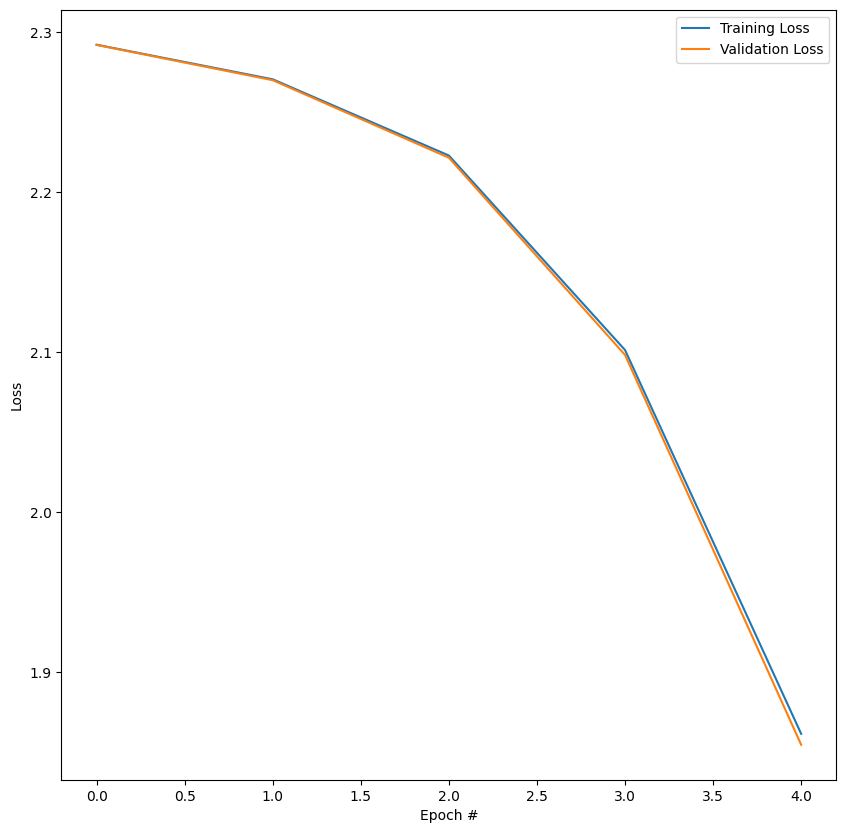

In [104]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [105]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [106]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.9780529544074484, accuracy: 65.02708333333334
Epoch 0: val. loss: 0.9671080974822349, val. accuracy: 65.19166666666666
Epoch 1: training loss: 0.4602937877495238, accuracy: 86.18541666666667
Epoch 1: val. loss: 0.4562935087274998, val. accuracy: 85.99166666666666
Epoch 2: training loss: 0.3294350579380989, accuracy: 90.29791666666667
Epoch 2: val. loss: 0.32557013408934815, val. accuracy: 90.24166666666666
Epoch 3: training loss: 0.2752241962292093, accuracy: 91.88125000000001
Epoch 3: val. loss: 0.27192884366563025, val. accuracy: 92.07499999999999
Epoch 4: training loss: 0.24853024187874287, accuracy: 92.49583333333334
Epoch 4: val. loss: 0.24692983830228765, val. accuracy: 92.27499999999999
CPU times: user 1min 8s, sys: 164 ms, total: 1min 8s
Wall time: 1min 9s


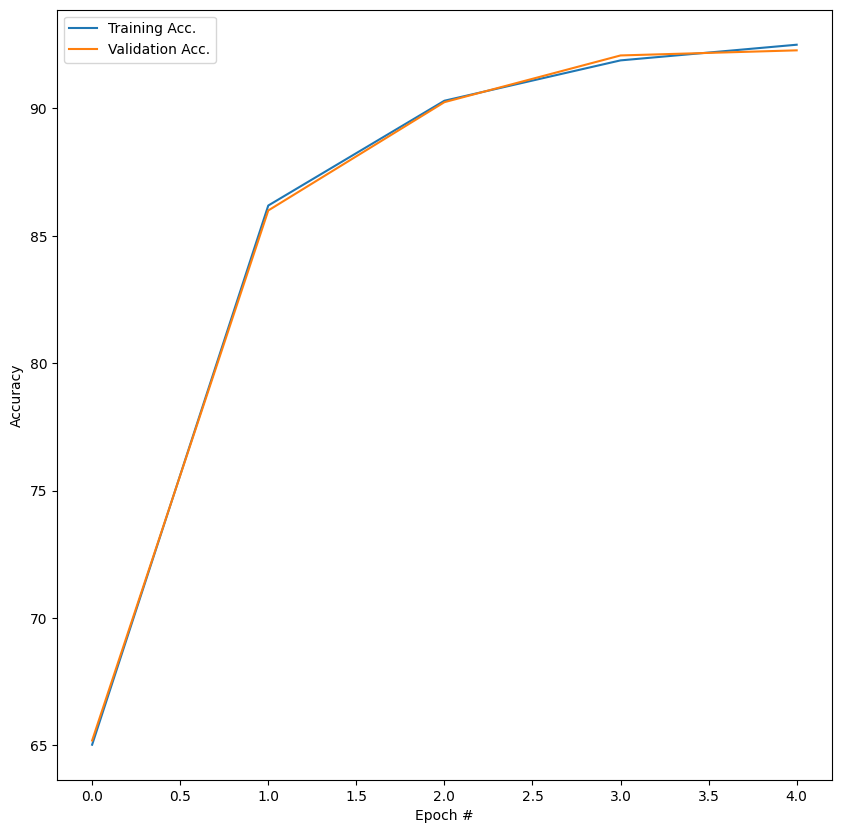

In [107]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

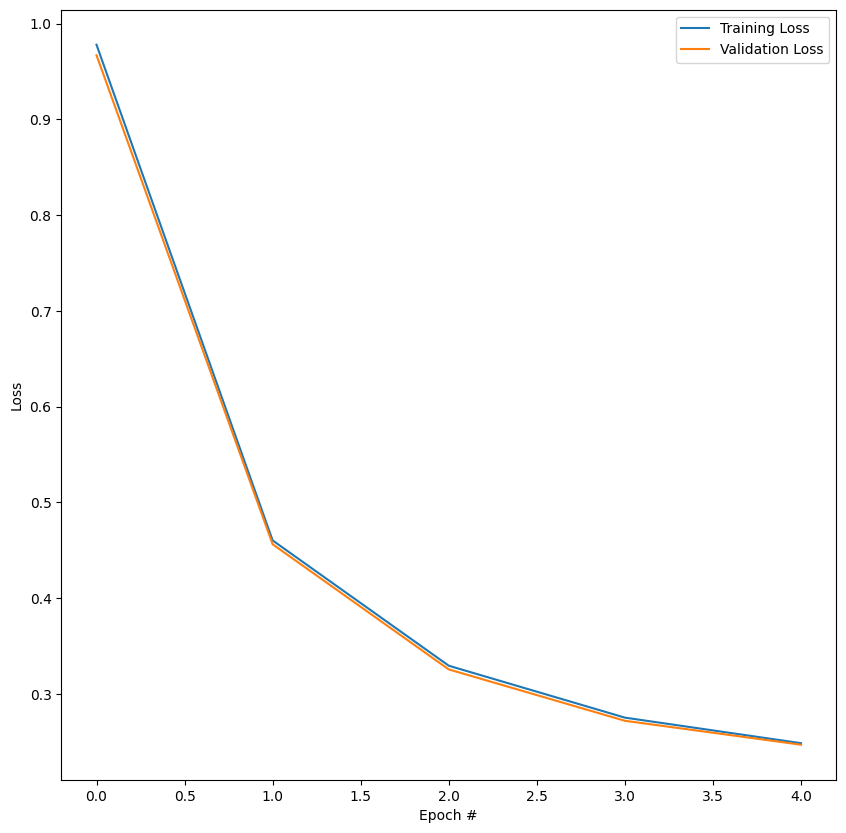

In [108]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Based on the results, we can form the following conclusions:

1. The learning rate below 0.01 does not lead to either high accuracy, low loss, or overall model convergence. One of the probable reasons is due to the low number of epochs (5). It is possible that with longer training the model will converge.

2. Overall, it appears that learning rate of 0.1 leads to the best convergence of the model in terms of both - accuracy and loss.

3. We observe that training with batch size of 32 and 64 leads to the more unstable learning, potentially resulting in the overfitting. Nonetheless, we will continue using those models for the comparison.

Next, we will test the models with parameters of lr=0.1 and batch size training of 32, 64, and 256 for different activation functions

### Testing Activation Functions

We will test the following activation functions apart of SGD: LeakyReLU, ELU (Exponential Linear Unit), and Tanh.

## Testing LeakyReLU for 3 models

In [110]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [111]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [112]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2126235314887017, accuracy: 93.63541666666667
Epoch 0: val. loss: 0.2189422744959593, val. accuracy: 93.31666666666666
Epoch 1: training loss: 0.14219751527750243, accuracy: 95.75
Epoch 1: val. loss: 0.155944594870011, val. accuracy: 95.35
Epoch 2: training loss: 0.11558835889011, accuracy: 96.45416666666667
Epoch 2: val. loss: 0.13519672339285413, val. accuracy: 96.05833333333334
Epoch 3: training loss: 0.10403654259381195, accuracy: 96.86458333333333
Epoch 3: val. loss: 0.13427530476388833, val. accuracy: 96.11666666666666
Epoch 4: training loss: 0.10619933730666525, accuracy: 96.65416666666667
Epoch 4: val. loss: 0.13684329773051043, val. accuracy: 95.86666666666666
CPU times: user 1min 23s, sys: 208 ms, total: 1min 23s
Wall time: 1min 25s


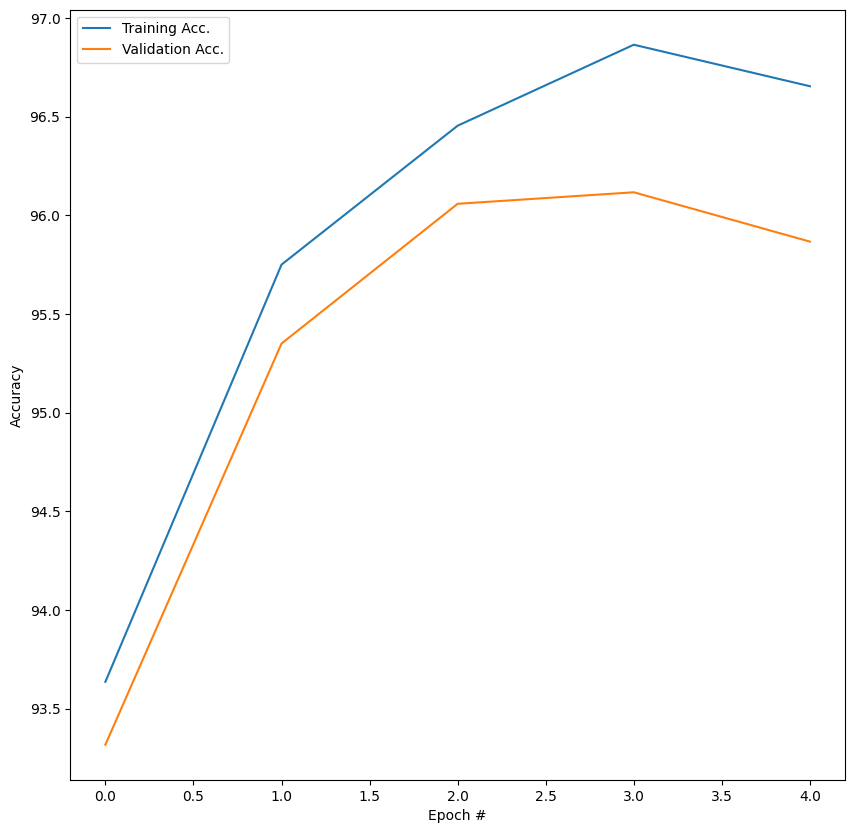

In [113]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

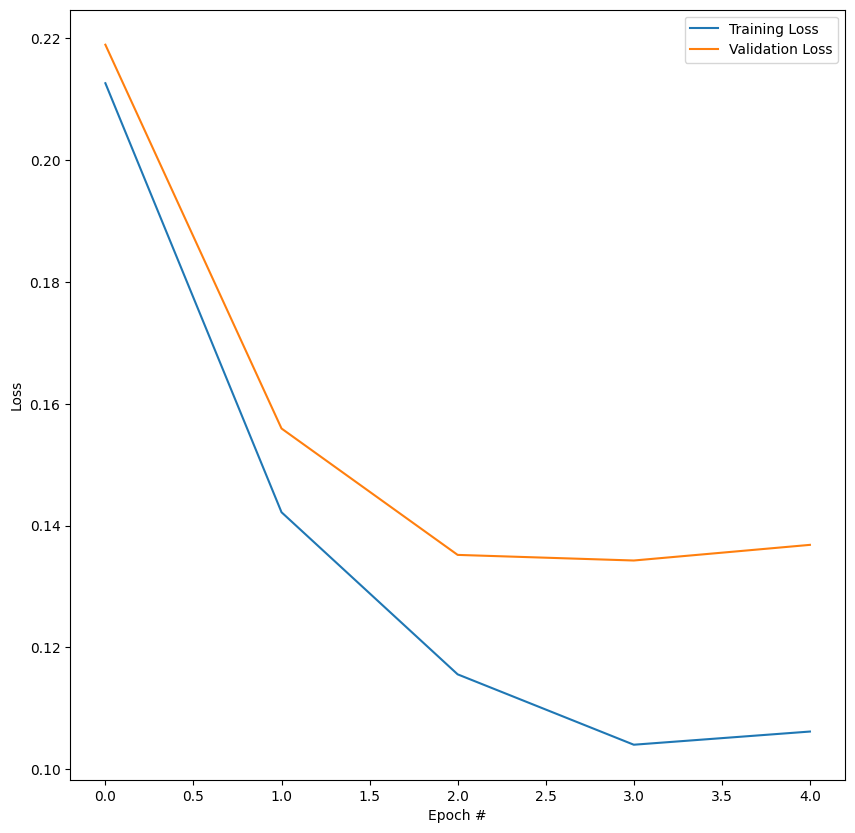

In [114]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [115]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [116]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2965066545108954, accuracy: 91.325
Epoch 0: val. loss: 0.29412588699066894, val. accuracy: 91.16666666666666
Epoch 1: training loss: 0.18433953601121902, accuracy: 94.53958333333333
Epoch 1: val. loss: 0.1873292611971339, val. accuracy: 94.27499999999999
Epoch 2: training loss: 0.143271888371557, accuracy: 95.675
Epoch 2: val. loss: 0.15191821964021693, val. accuracy: 95.42500000000001
Epoch 3: training loss: 0.11820306556050976, accuracy: 96.56875000000001
Epoch 3: val. loss: 0.1339423786105707, val. accuracy: 95.95
Epoch 4: training loss: 0.10298428604627649, accuracy: 96.88333333333333
Epoch 4: val. loss: 0.1256416121255012, val. accuracy: 96.08333333333333
CPU times: user 1min 16s, sys: 182 ms, total: 1min 17s
Wall time: 1min 18s


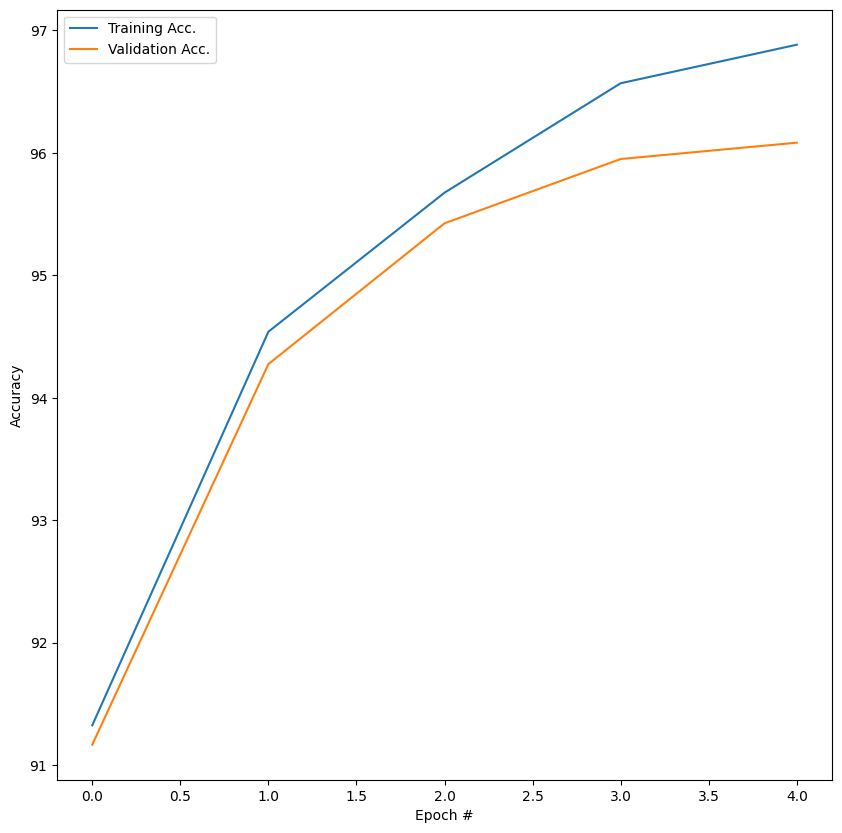

In [117]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

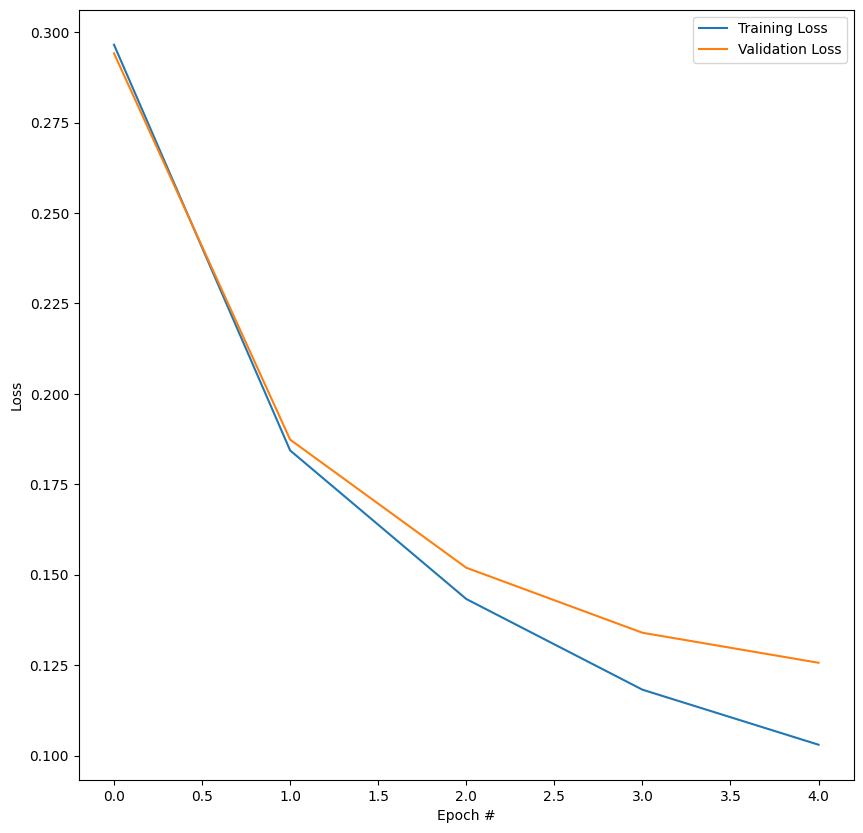

In [118]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [119]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [120]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7573331493012448, accuracy: 76.47916666666667
Epoch 0: val. loss: 0.7492291394700396, val. accuracy: 76.34166666666667
Epoch 1: training loss: 0.3997980519495112, accuracy: 88.27708333333332
Epoch 1: val. loss: 0.3894292154210679, val. accuracy: 88.21666666666667
Epoch 2: training loss: 0.3141131723656299, accuracy: 90.98958333333333
Epoch 2: val. loss: 0.3083262906429615, val. accuracy: 90.64999999999999
Epoch 3: training loss: 0.2696764500058712, accuracy: 92.18125
Epoch 3: val. loss: 0.27004224759467105, val. accuracy: 91.90833333333333
Epoch 4: training loss: 0.22550877572057096, accuracy: 93.45833333333333
Epoch 4: val. loss: 0.22712556478825022, val. accuracy: 93.21666666666667
CPU times: user 1min 8s, sys: 161 ms, total: 1min 9s
Wall time: 1min 9s


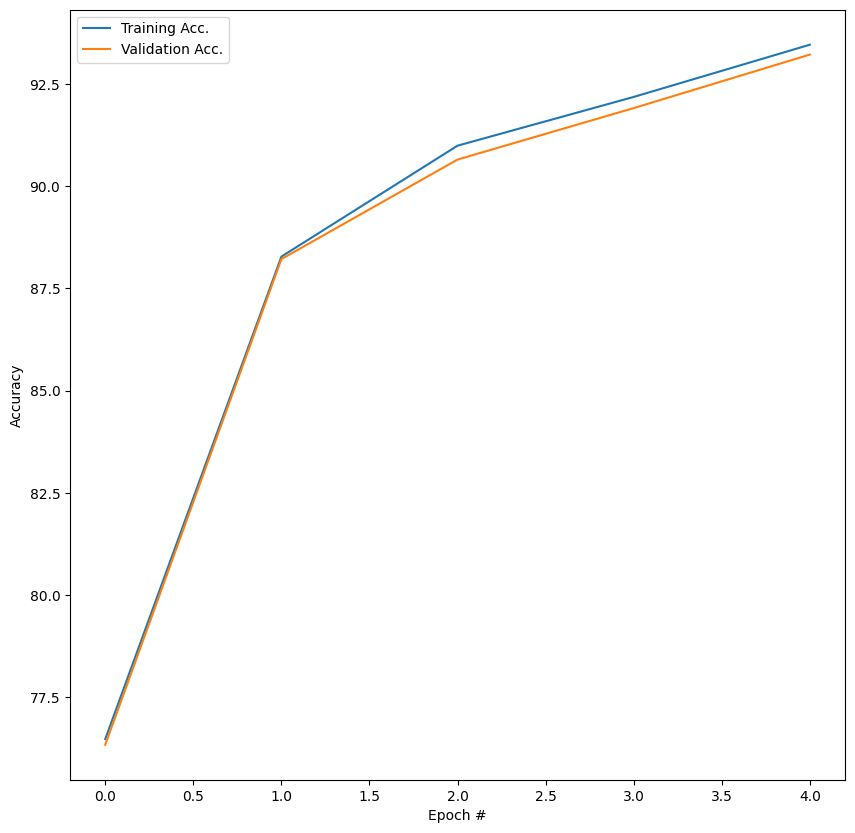

In [121]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

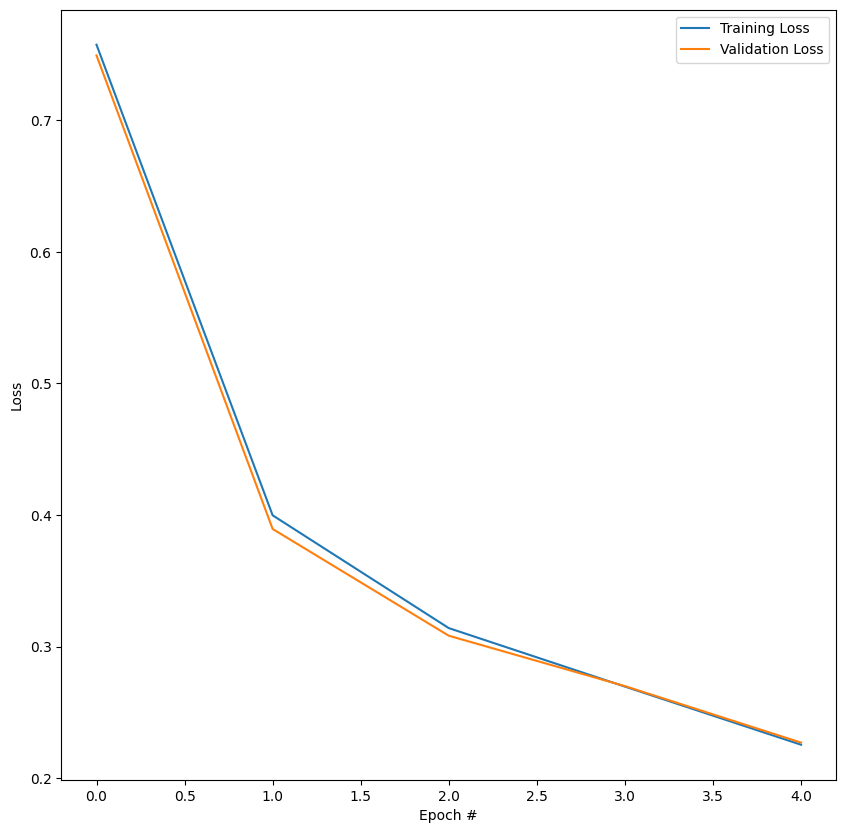

In [122]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

## Testing ELU for 3 models

In [123]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [124]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [125]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.22097532054161032, accuracy: 93.40416666666667
Epoch 0: val. loss: 0.21890690537293753, val. accuracy: 93.60833333333333
Epoch 1: training loss: 0.168200743911167, accuracy: 94.84791666666666
Epoch 1: val. loss: 0.17259672073026497, val. accuracy: 94.79166666666666
Epoch 2: training loss: 0.12769432165597877, accuracy: 96.03958333333334
Epoch 2: val. loss: 0.13966663594792286, val. accuracy: 95.85000000000001
Epoch 3: training loss: 0.10912262751441448, accuracy: 96.57708333333333
Epoch 3: val. loss: 0.1217199973401924, val. accuracy: 96.28333333333333
Epoch 4: training loss: 0.09483972528786398, accuracy: 97.08541666666667
Epoch 4: val. loss: 0.11441649551006655, val. accuracy: 96.6
CPU times: user 1min 23s, sys: 172 ms, total: 1min 23s
Wall time: 1min 24s


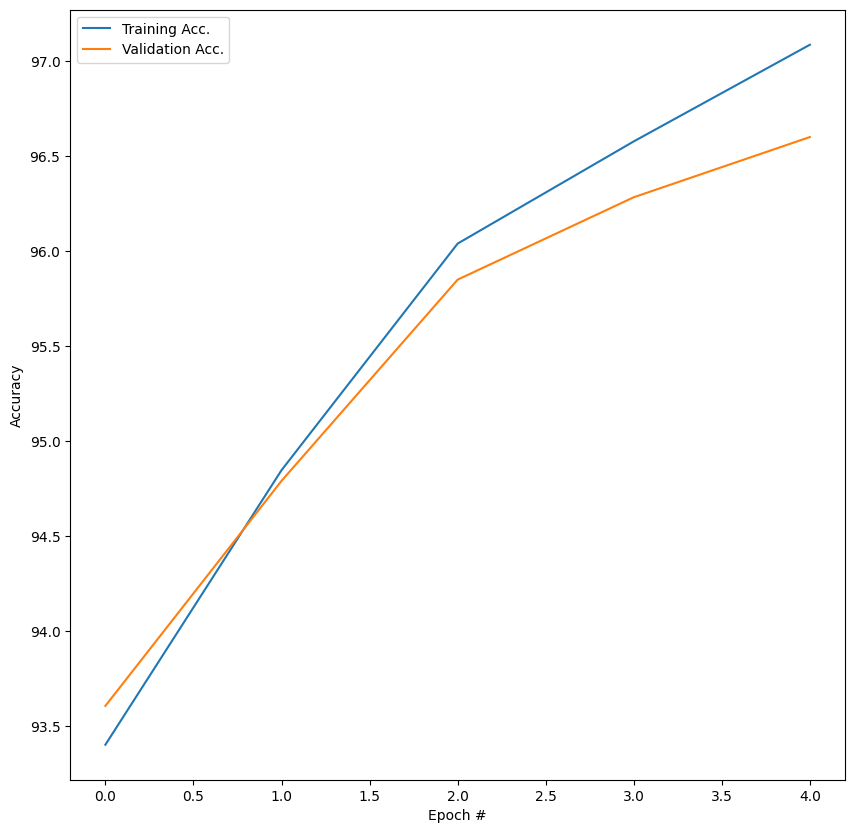

In [126]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

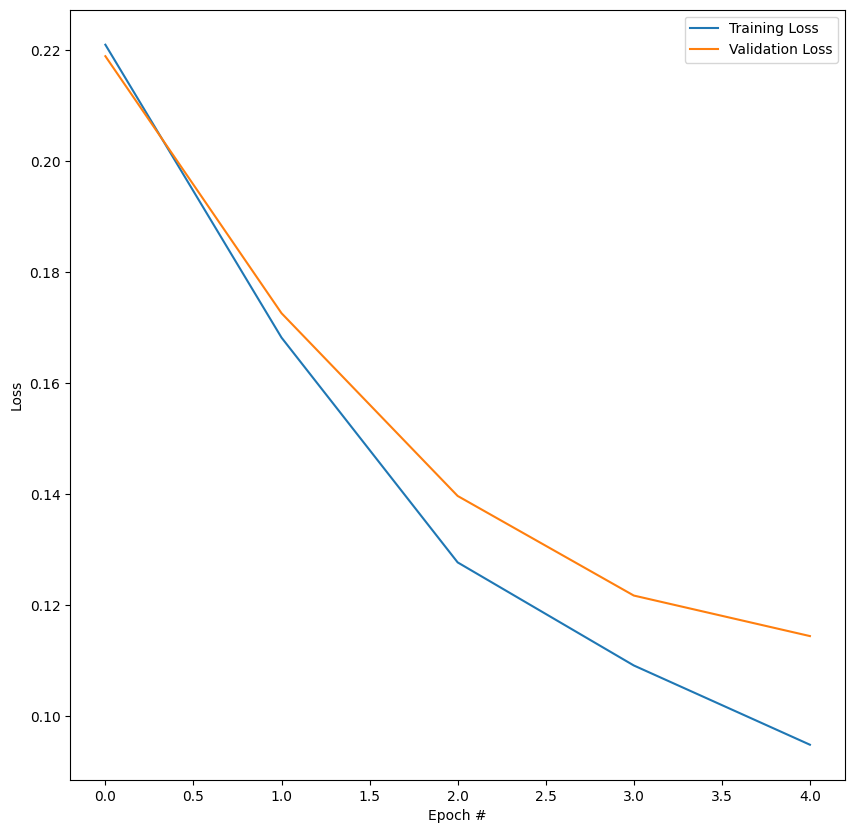

In [127]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [128]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [129]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.28262363697091736, accuracy: 91.65833333333333
Epoch 0: val. loss: 0.27701675210227356, val. accuracy: 91.43333333333334
Epoch 1: training loss: 0.21309825437764326, accuracy: 93.75833333333333
Epoch 1: val. loss: 0.2125108707299892, val. accuracy: 93.59166666666667
Epoch 2: training loss: 0.16613148067891598, accuracy: 95.08125
Epoch 2: val. loss: 0.17188953009850166, val. accuracy: 94.81666666666668
Epoch 3: training loss: 0.14478611220419407, accuracy: 95.575
Epoch 3: val. loss: 0.1542974816674882, val. accuracy: 95.38333333333333
Epoch 4: training loss: 0.12856427253037692, accuracy: 95.97916666666667
Epoch 4: val. loss: 0.1403665140449525, val. accuracy: 95.625
CPU times: user 1min 15s, sys: 157 ms, total: 1min 16s
Wall time: 1min 16s


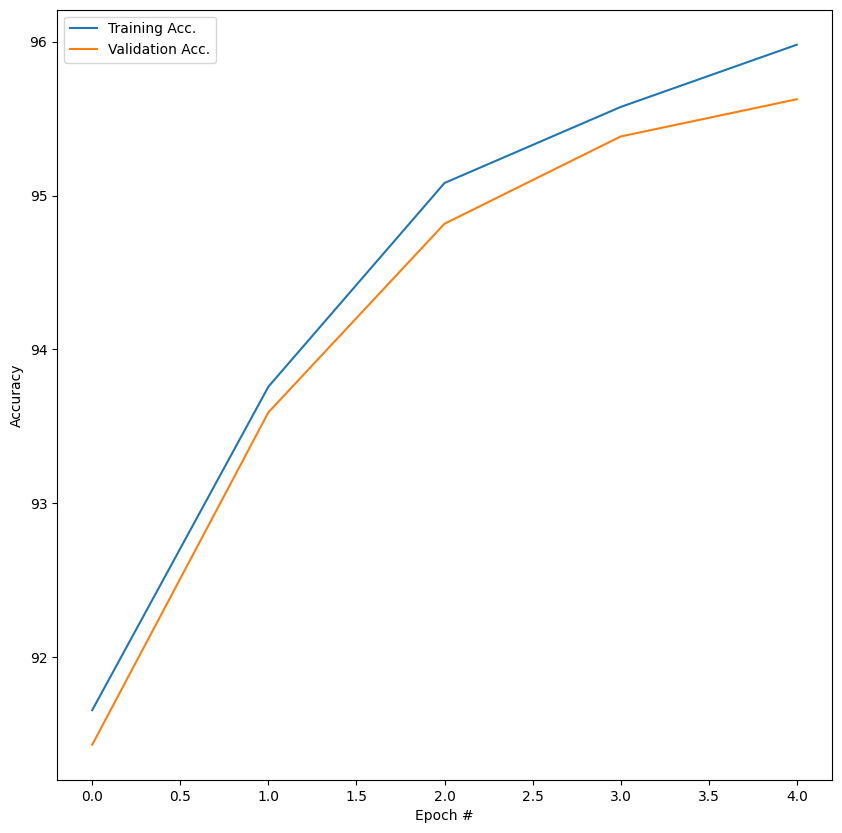

In [130]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

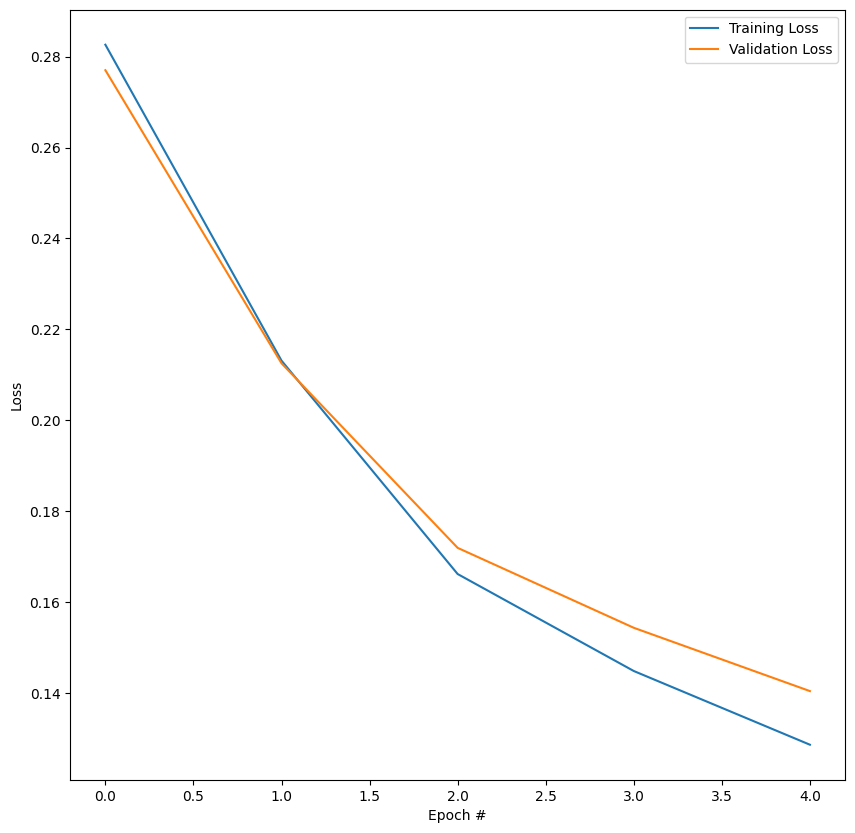

In [131]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [132]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [133]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.4992829686466684, accuracy: 85.53541666666666
Epoch 0: val. loss: 0.4929014412646598, val. accuracy: 85.45
Epoch 1: training loss: 0.3629944834937441, accuracy: 89.57291666666667
Epoch 1: val. loss: 0.3535596487369943, val. accuracy: 89.33333333333333
Epoch 2: training loss: 0.31940048195897264, accuracy: 90.73958333333333
Epoch 2: val. loss: 0.3125274292332061, val. accuracy: 90.53333333333333
Epoch 3: training loss: 0.2804908700128819, accuracy: 91.85833333333333
Epoch 3: val. loss: 0.2754846288168684, val. accuracy: 91.55
Epoch 4: training loss: 0.2523134377725581, accuracy: 92.61458333333333
Epoch 4: val. loss: 0.24971157534325378, val. accuracy: 92.33333333333333
CPU times: user 1min 9s, sys: 141 ms, total: 1min 9s
Wall time: 1min 9s


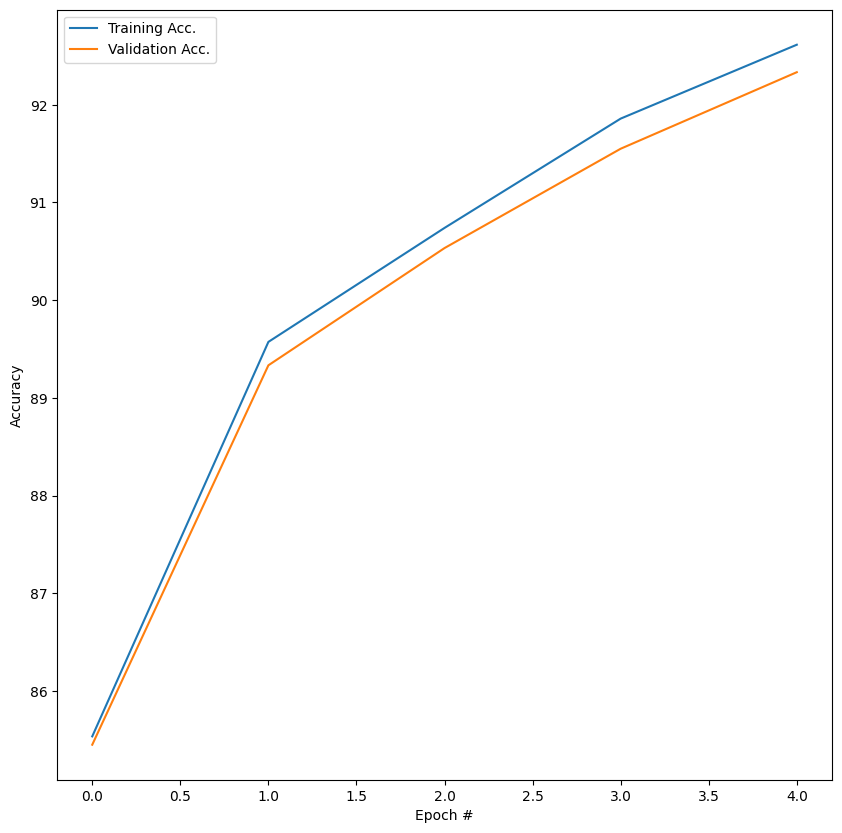

In [134]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

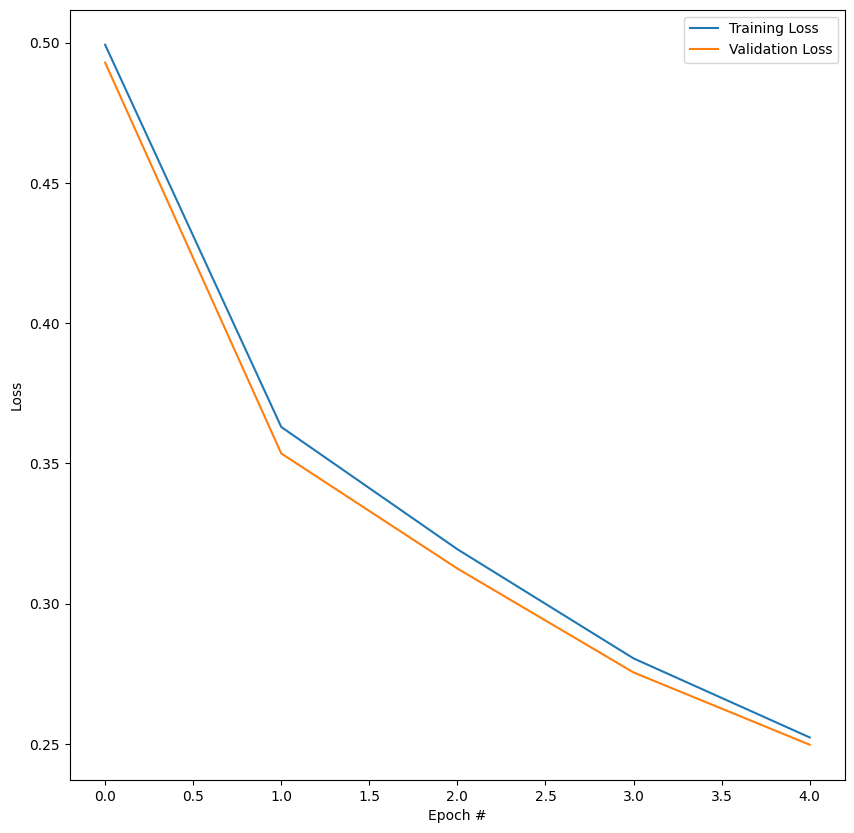

In [135]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

## Testing Tanh for 3 models

In [136]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [137]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [138]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.23684456944465637, accuracy: 92.98541666666667
Epoch 0: val. loss: 0.23338355398674807, val. accuracy: 92.85
Epoch 1: training loss: 0.17740952018275857, accuracy: 94.68124999999999
Epoch 1: val. loss: 0.18302272639920314, val. accuracy: 94.39166666666667
Epoch 2: training loss: 0.14909782928569862, accuracy: 95.54166666666667
Epoch 2: val. loss: 0.1594533604569733, val. accuracy: 95.16666666666667
Epoch 3: training loss: 0.11452820122614503, accuracy: 96.55416666666666
Epoch 3: val. loss: 0.12950102120017012, val. accuracy: 96.10833333333333
Epoch 4: training loss: 0.10372120865496497, accuracy: 96.84583333333333
Epoch 4: val. loss: 0.12176733937549095, val. accuracy: 96.25833333333334
CPU times: user 1min 22s, sys: 180 ms, total: 1min 22s
Wall time: 1min 23s


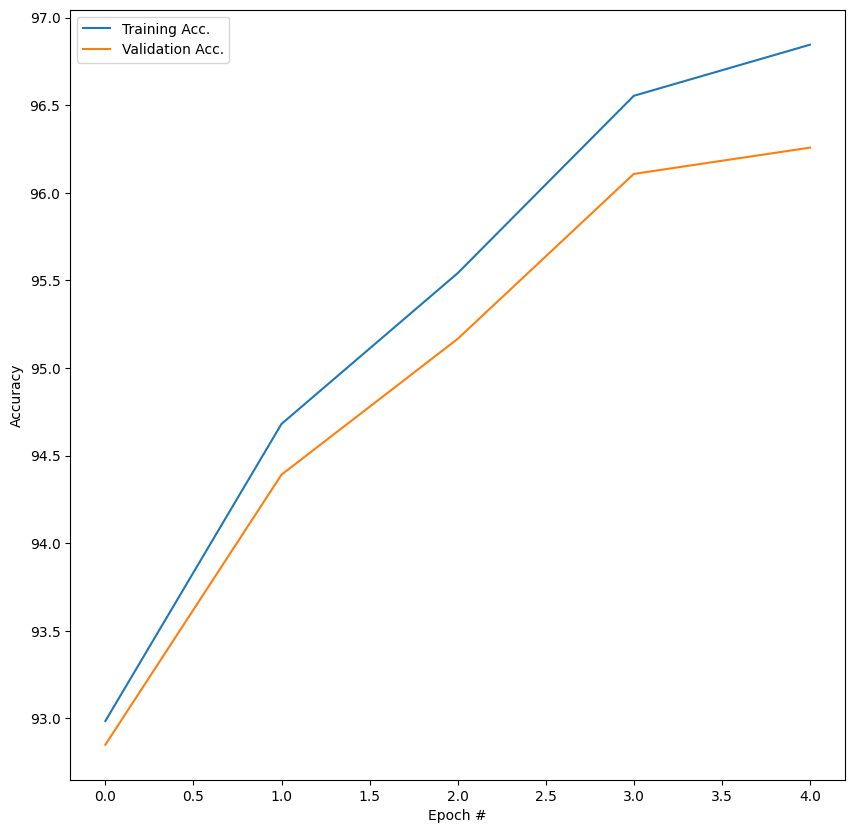

In [139]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

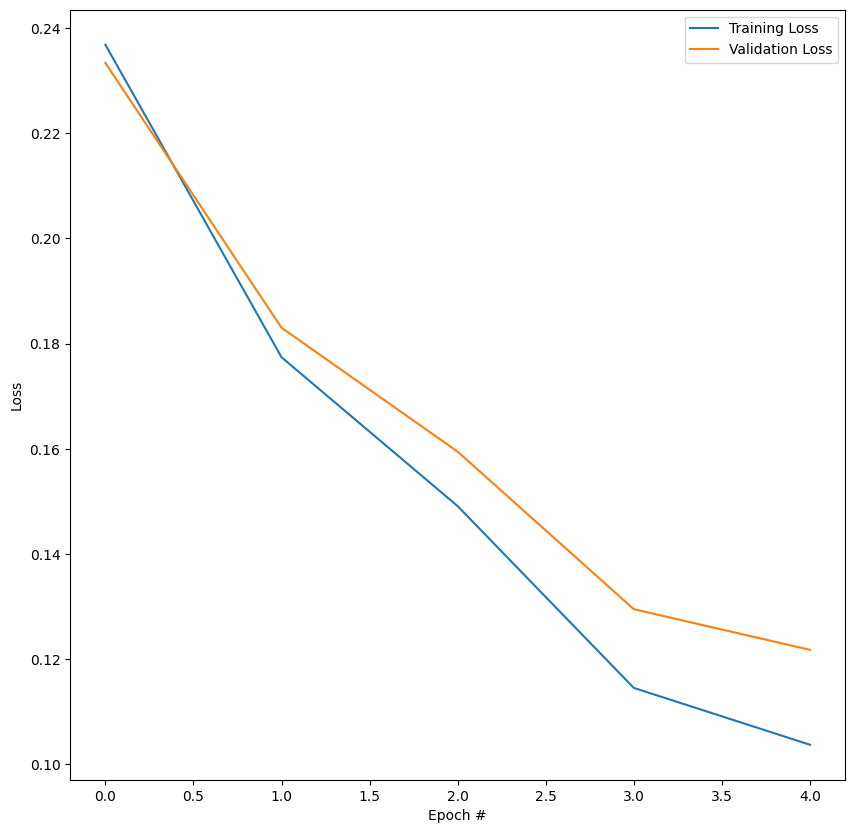

In [140]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [141]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [142]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2980715017418067, accuracy: 91.55416666666667
Epoch 0: val. loss: 0.2913727719495271, val. accuracy: 91.4
Epoch 1: training loss: 0.2268511196821928, accuracy: 93.35625
Epoch 1: val. loss: 0.22660595154825677, val. accuracy: 93.14166666666667
Epoch 2: training loss: 0.1832135719905297, accuracy: 94.59375
Epoch 2: val. loss: 0.187714189429708, val. accuracy: 94.27499999999999
Epoch 3: training loss: 0.1551777640581131, accuracy: 95.40625
Epoch 3: val. loss: 0.16416777669392685, val. accuracy: 94.80833333333332
Epoch 4: training loss: 0.13804811489830415, accuracy: 95.83541666666666
Epoch 4: val. loss: 0.14960028874152836, val. accuracy: 95.43333333333334
CPU times: user 1min 15s, sys: 136 ms, total: 1min 15s
Wall time: 1min 16s


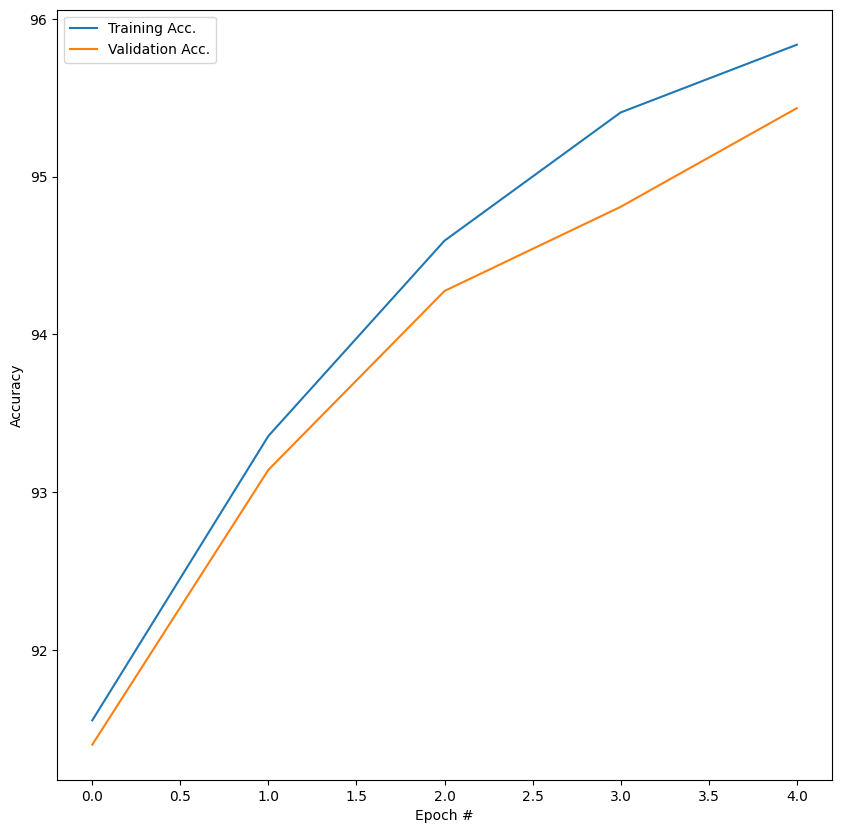

In [143]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

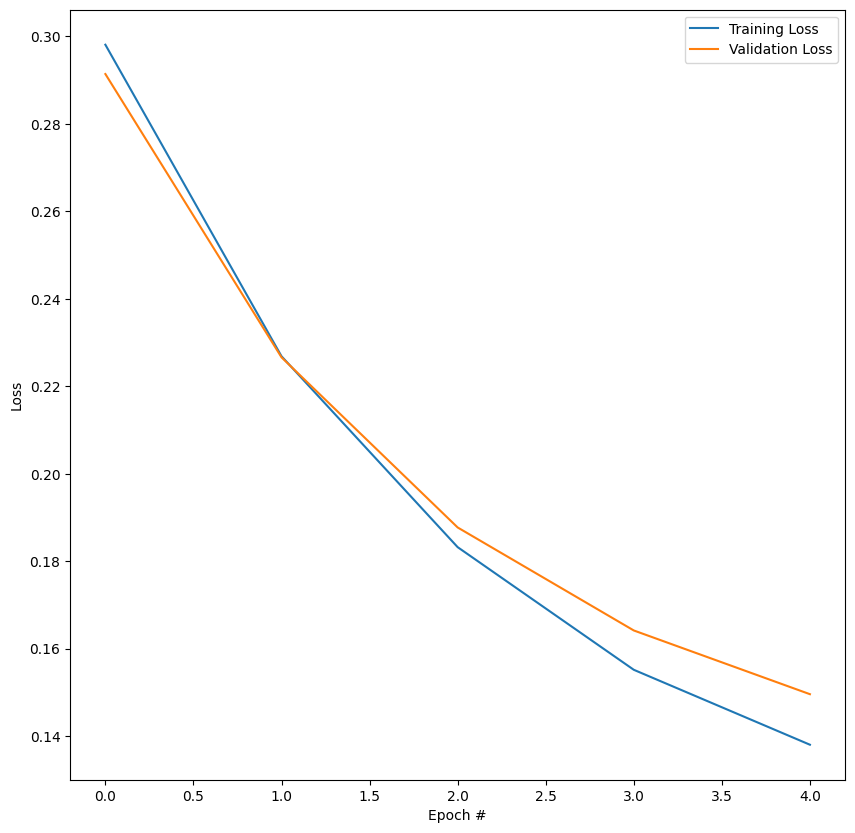

In [144]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [145]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [146]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5617675608459939, accuracy: 84.65416666666667
Epoch 0: val. loss: 0.5581445053536841, val. accuracy: 84.46666666666667
Epoch 1: training loss: 0.3738268550406111, accuracy: 89.525
Epoch 1: val. loss: 0.3670357795471841, val. accuracy: 89.39166666666667
Epoch 2: training loss: 0.3211088904199448, accuracy: 90.92916666666667
Epoch 2: val. loss: 0.3143516525309137, val. accuracy: 90.79166666666667
Epoch 3: training loss: 0.28594475833976524, accuracy: 91.84375
Epoch 3: val. loss: 0.28117544885645523, val. accuracy: 91.61666666666667
Epoch 4: training loss: 0.26618635868455504, accuracy: 92.33958333333334
Epoch 4: val. loss: 0.26430401079198146, val. accuracy: 92.01666666666667
CPU times: user 1min 9s, sys: 169 ms, total: 1min 9s
Wall time: 1min 9s


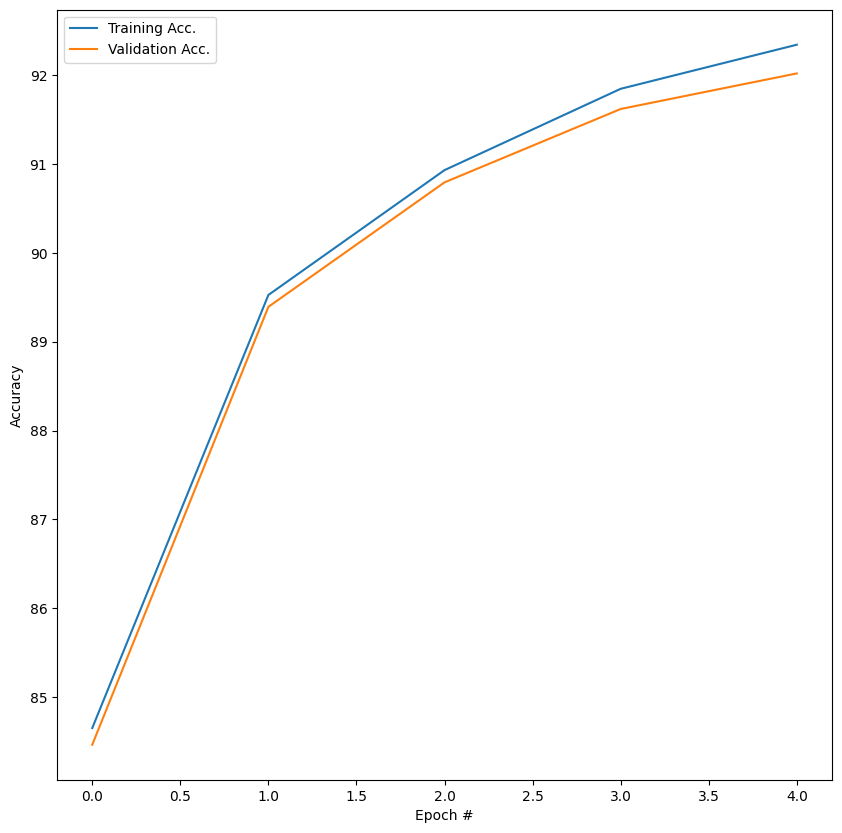

In [147]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

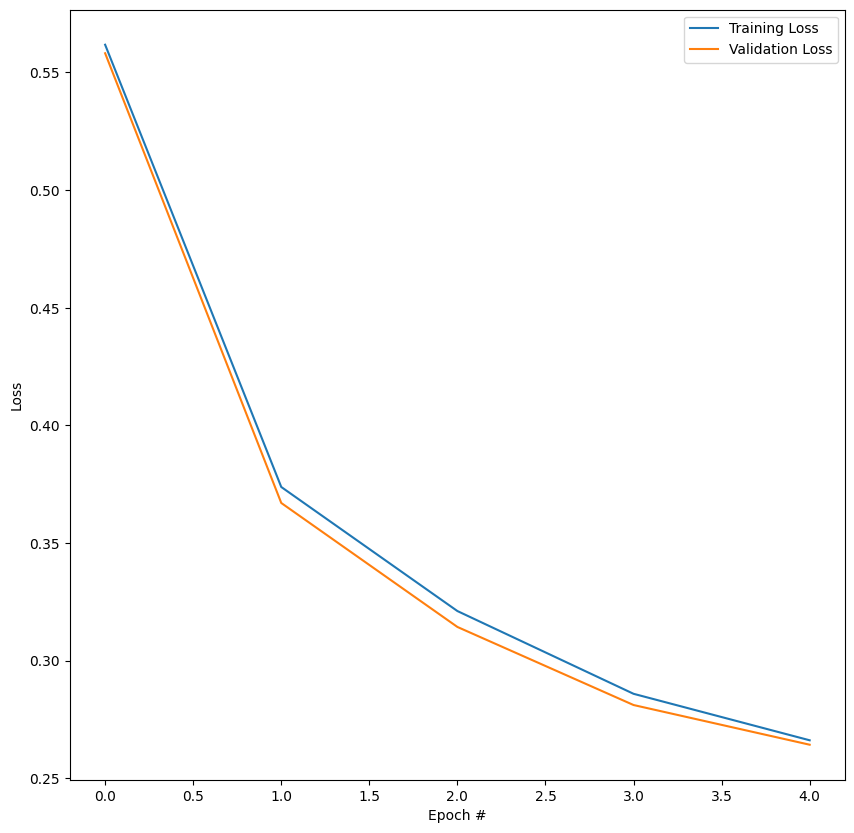

In [148]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Our experiments revealed the following:

1. Overall, the difference in activation function did not reveal any specific improvements or downsides.

2. We observe that LeakyReLU demonstrated the best performance for the model with parameters of batch size 256 and lr=0.1.

3. For the models with batch size of 32, we identify ELU as the best performing activation

4. For the model with batch size of 64, we identify Tanh as the best performing activation. While the results between ELU and Tanh are similar, there is a smaller discrepancies in loss and acc curves for Tanh.

To identify the best performing model, we will conduct the final comparison of 4 models - all of them having learning rate of 0.1:

1. Batch size 32 + activation ELU

2. Batch size 64 + activation Tanh

3. Batch size 128 + activation LeakyReLU

4. Batch size 256 + activation LeakyReLU

Final Testing to select the best model

### NOTE: We are increasing training to 10 epochs

### Batch size 32 + activation ELU

In [162]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [163]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [164]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2345622413108746, accuracy: 93.025
Epoch 0: val. loss: 0.23439183183014392, val. accuracy: 92.625
Epoch 1: training loss: 0.1666218853732571, accuracy: 94.94375000000001
Epoch 1: val. loss: 0.17506517612437408, val. accuracy: 94.70833333333334
Epoch 2: training loss: 0.13107285519037395, accuracy: 96.025
Epoch 2: val. loss: 0.14368675621723134, val. accuracy: 95.625
Epoch 3: training loss: 0.10968781206586088, accuracy: 96.57083333333333
Epoch 3: val. loss: 0.12513672766958675, val. accuracy: 96.33333333333334
Epoch 4: training loss: 0.09392370276960234, accuracy: 97.04166666666667
Epoch 4: val. loss: 0.11267449700149397, val. accuracy: 96.59166666666667
Epoch 5: training loss: 0.08626376880519092, accuracy: 97.28541666666666
Epoch 5: val. loss: 0.1084008703349779, val. accuracy: 96.74166666666667
Epoch 6: training loss: 0.08346209708197663, accuracy: 97.36875
Epoch 6: val. loss: 0.10911841841166219, val. accuracy: 96.64166666666667
Epoch 7: training loss: 0.0

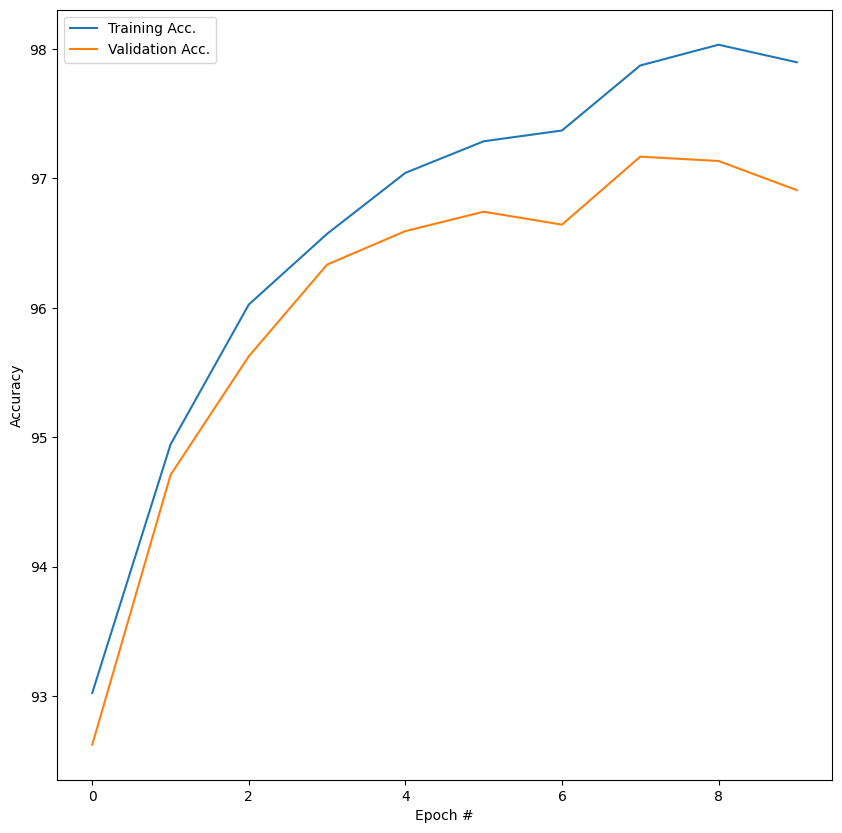

In [165]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

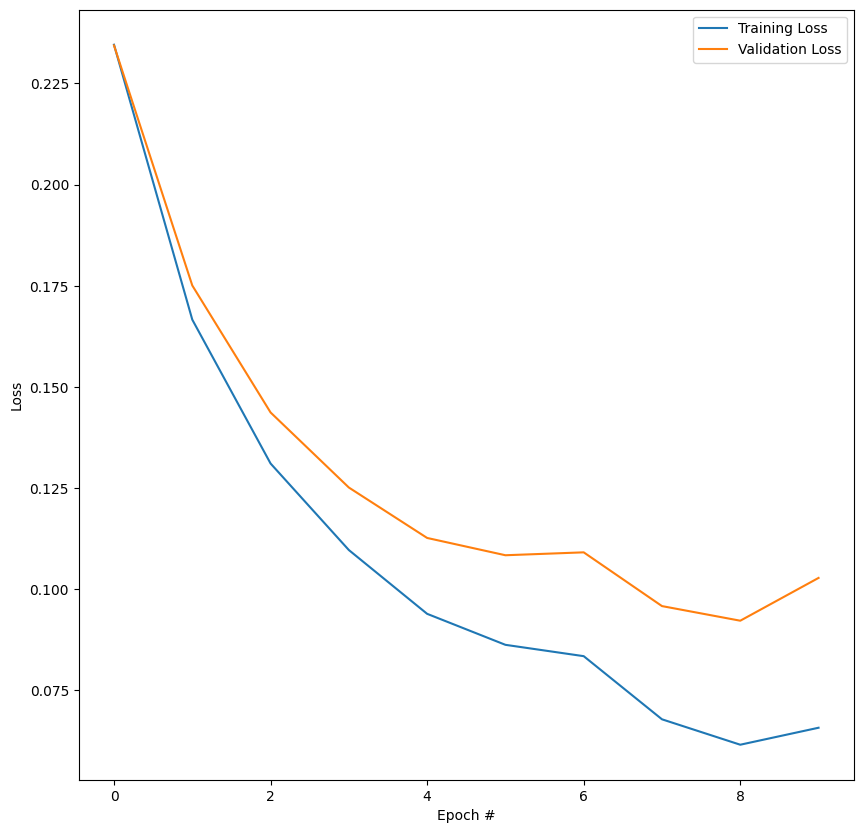

In [166]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Batch size 64 + activation Tanh

In [167]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [168]:
batch_size = 64
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [169]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2977986634671688, accuracy: 91.52916666666667
Epoch 0: val. loss: 0.2920012422936394, val. accuracy: 91.44166666666666
Epoch 1: training loss: 0.22217334962884586, accuracy: 93.54375
Epoch 1: val. loss: 0.22281625720256187, val. accuracy: 93.23333333333333
Epoch 2: training loss: 0.18634010323385397, accuracy: 94.4625
Epoch 2: val. loss: 0.1915485230571729, val. accuracy: 94.05
Epoch 3: training loss: 0.16067681714892387, accuracy: 95.20625
Epoch 3: val. loss: 0.16923463384204723, val. accuracy: 94.95
Epoch 4: training loss: 0.14128496322532494, accuracy: 95.75625
Epoch 4: val. loss: 0.15495360187908752, val. accuracy: 95.21666666666667
Epoch 5: training loss: 0.12932284036527078, accuracy: 96.13958333333333
Epoch 5: val. loss: 0.14545256217466074, val. accuracy: 95.58333333333333
Epoch 6: training loss: 0.11829713340848684, accuracy: 96.44791666666667
Epoch 6: val. loss: 0.1375199774617052, val. accuracy: 95.81666666666668
Epoch 7: training loss: 0.1054206335

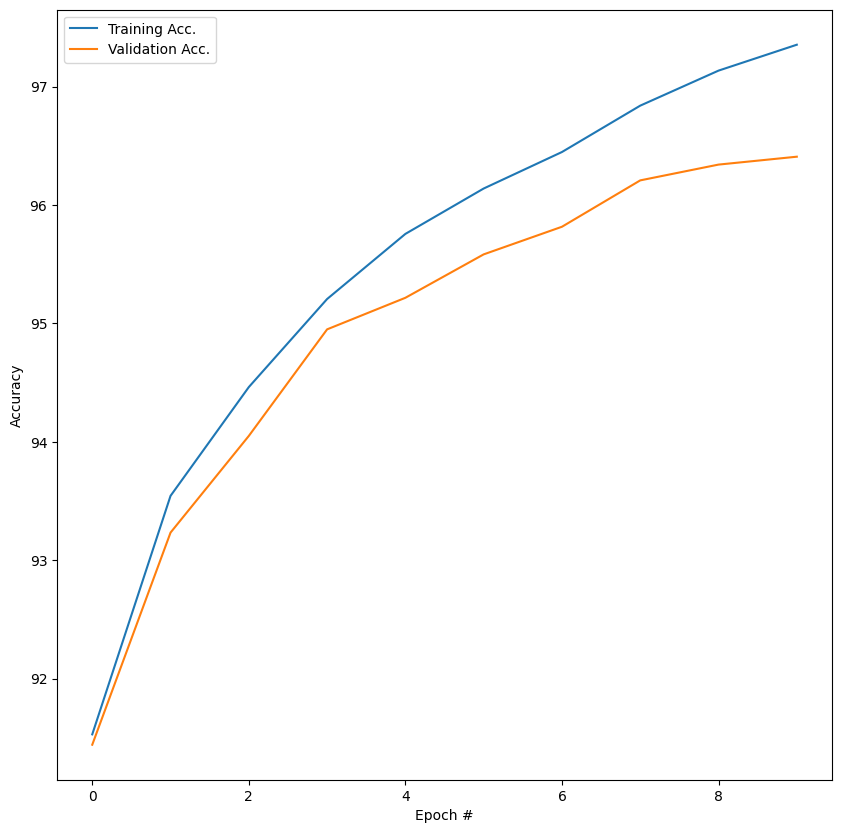

In [170]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

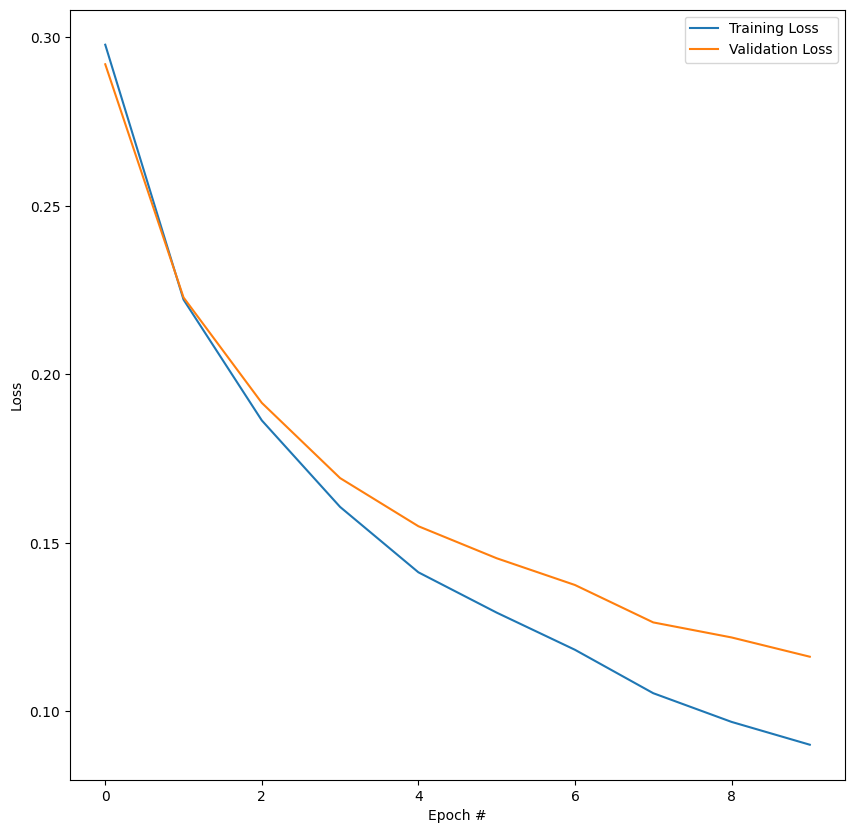

In [171]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Batch size 128 + activation LeakyReLU

In [172]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [173]:
batch_size = 128
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [174]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.4205427935520808, accuracy: 87.875
Epoch 0: val. loss: 0.4158516802052234, val. accuracy: 87.85833333333333
Epoch 1: training loss: 0.27048422195514044, accuracy: 92.27499999999999
Epoch 1: val. loss: 0.264887754270371, val. accuracy: 92.08333333333333
Epoch 2: training loss: 0.1949359711011251, accuracy: 94.27499999999999
Epoch 2: val. loss: 0.19477925338643662, val. accuracy: 94.125
Epoch 3: training loss: 0.15505383001764617, accuracy: 95.50208333333333
Epoch 3: val. loss: 0.16099726622726054, val. accuracy: 95.19166666666666
Epoch 4: training loss: 0.13913969099521636, accuracy: 95.9375
Epoch 4: val. loss: 0.14708125198933672, val. accuracy: 95.55
Epoch 5: training loss: 0.11977475304404894, accuracy: 96.5125
Epoch 5: val. loss: 0.13496451063993128, val. accuracy: 96.01666666666667
Epoch 6: training loss: 0.10752951672673225, accuracy: 96.78958333333333
Epoch 6: val. loss: 0.12358266933563541, val. accuracy: 96.30833333333332
Epoch 7: training loss: 0.1030

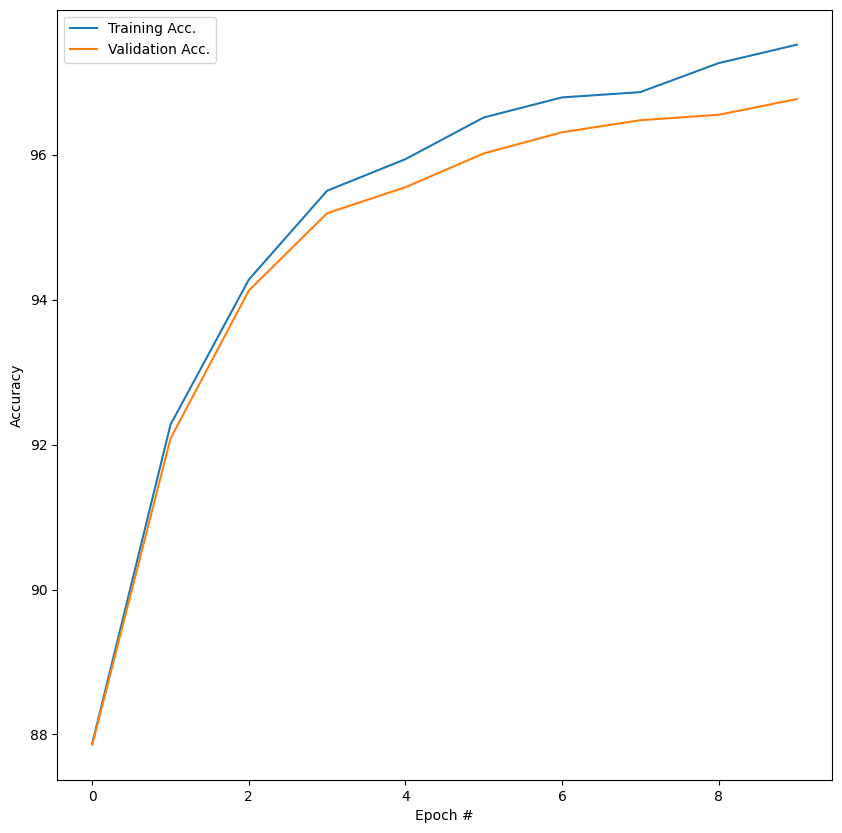

In [175]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

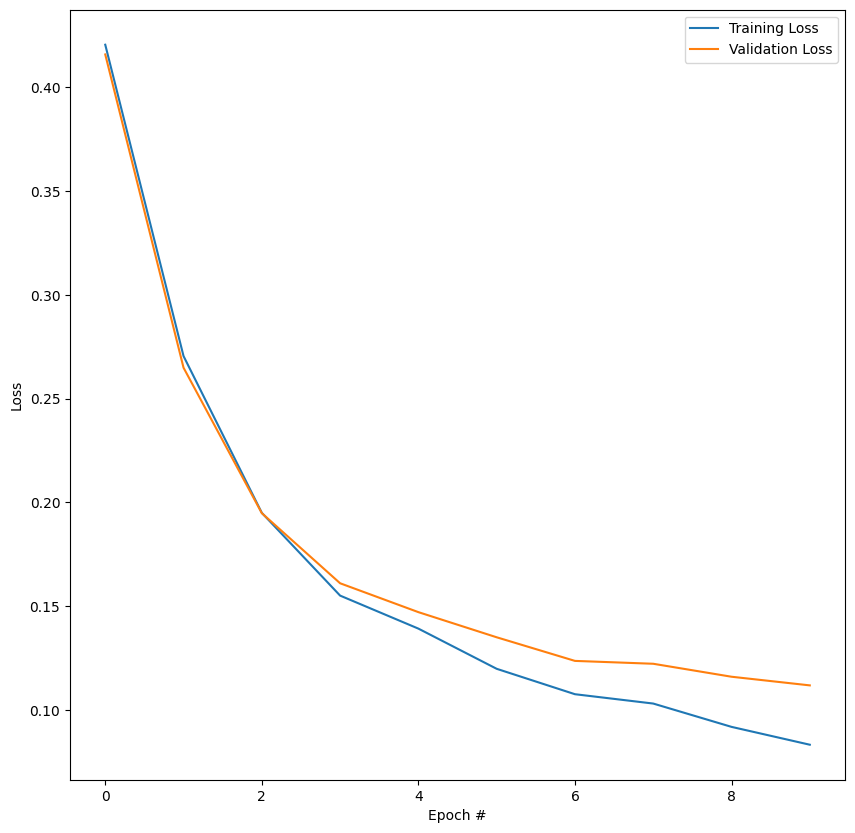

In [176]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

### Batch size 256 + activation LeakyReLU

In [177]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [178]:
batch_size = 256
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [179]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 1.009116196886022, accuracy: 68.56666666666666
Epoch 0: val. loss: 1.0078072078684543, val. accuracy: 67.83333333333333
Epoch 1: training loss: 0.41428559542970456, accuracy: 87.68125
Epoch 1: val. loss: 0.4063438272222559, val. accuracy: 87.4
Epoch 2: training loss: 0.30870713563041485, accuracy: 90.87916666666666
Epoch 2: val. loss: 0.30149618044812626, val. accuracy: 90.7
Epoch 3: training loss: 0.2752139442303079, accuracy: 91.70833333333334
Epoch 3: val. loss: 0.2697862611806139, val. accuracy: 91.58333333333334
Epoch 4: training loss: 0.2380448449799355, accuracy: 92.72916666666666
Epoch 4: val. loss: 0.23382488527196518, val. accuracy: 92.71666666666667
Epoch 5: training loss: 0.18750225982450425, accuracy: 94.4625
Epoch 5: val. loss: 0.18746948828722568, val. accuracy: 94.325
Epoch 6: training loss: 0.16910388661508866, accuracy: 94.98124999999999
Epoch 6: val. loss: 0.1712827427273101, val. accuracy: 94.79166666666666
Epoch 7: training loss: 0.150653312

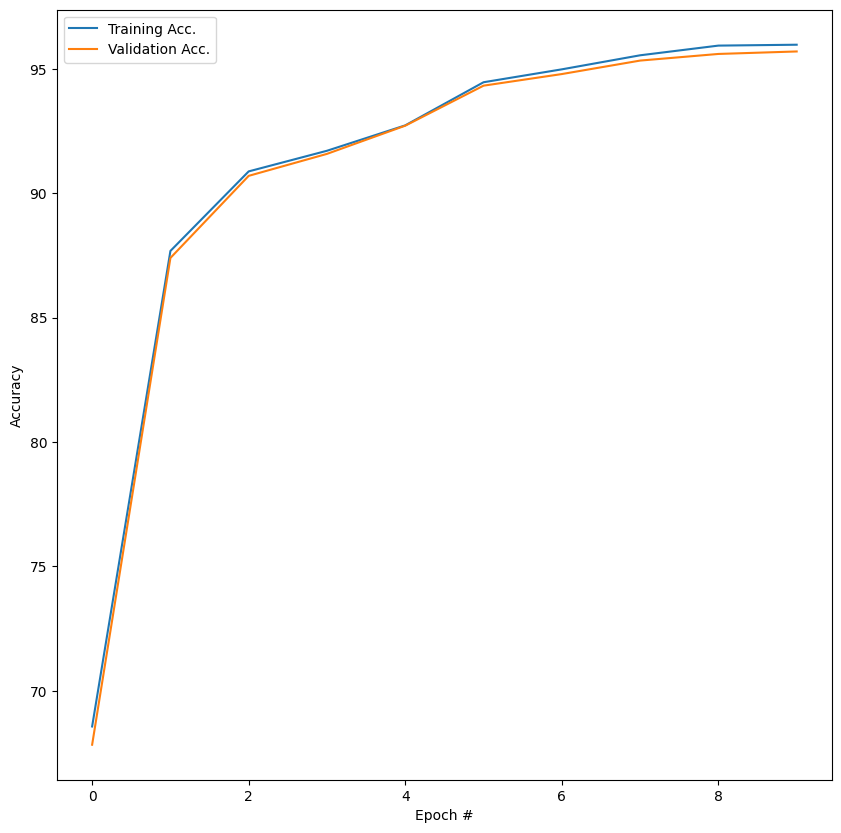

In [180]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

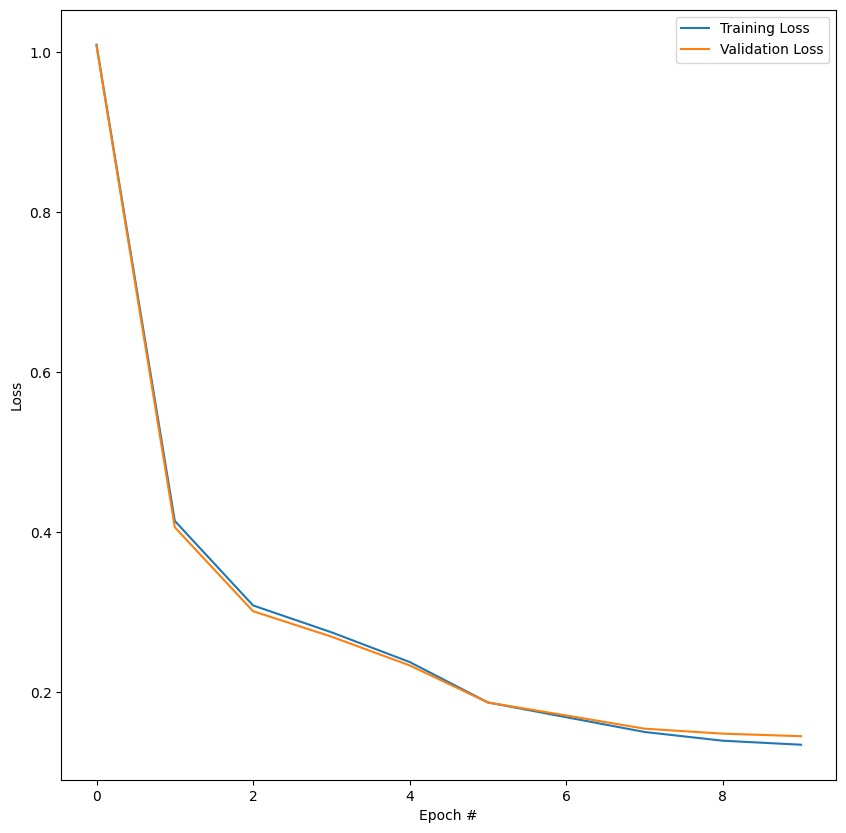

In [181]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

We make the following observations:

1. The highes accuracy achieved by the model was between 96 and 97%. However, we note that models with batch size 32, 64, and 128 all achived high accuracy at the varying number of epochs. For batch size 32 and 128: epoch 10, for 64: epoch 4.

2. The lowest loss for each model was at the different time, however, for batch sizes 32, 64, and 128 the divergence between val. and training loss was increasing after approximately epoch 4-5. Therefore, next we analyze the performance of each model after we began to observe the said divergence

3. For batch size 32: epoch 4. Difference in accuracy: 0.24. Difference in loss: .0155. Training Loss: 0.10968781206586088. Training Accuracy: 96.57083333333333

4. For batch size 64: epoch 6. Difference in accuracy: 0.6313. Difference in loss: 0.0187. Training Loss: 0.11829713340848684. Training Accuracy 96.44791666666667

5. For batch size 128: epoch 5. Difference in accuracy: 0.3875. Difference in loss: 0.008. Training Loss: 0.13913969099521636. Training Accuracy 95.9375

6. For batch size 256: epoch 10. Difference in accuracy: 0.27. Difference in loss: 0.0107. Training Loss: 0.13471699307890647. Training Accuracy 95.97083333333333.

Based on our finding, we select the optiomal model as model with batch size of 32, activation function of ELU, learning rate of 0.1. The model will be trained for 4 epochs.

Next, we will retrain the model for 4 epochs and re-evaluate it on the test data.

In [183]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [184]:
batch_size = 32
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [185]:
%%time

epochs = 4
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.21883909947549304, accuracy: 93.60000000000001
Epoch 0: val. loss: 0.21391204924881457, val. accuracy: 93.50833333333334
Epoch 1: training loss: 0.15438956430306036, accuracy: 95.25625
Epoch 1: val. loss: 0.1595224229072531, val. accuracy: 95.1
Epoch 2: training loss: 0.1416070140833035, accuracy: 95.68541666666667
Epoch 2: val. loss: 0.14893194036682447, val. accuracy: 95.51666666666667
Epoch 3: training loss: 0.10707968754678343, accuracy: 96.675
Epoch 3: val. loss: 0.12252750863259038, val. accuracy: 96.30833333333332
CPU times: user 1min 8s, sys: 134 ms, total: 1min 8s
Wall time: 1min 12s


In [186]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.1223, test accuracy: 96.03%


Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


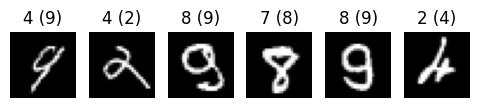

In [187]:
show_failures(nonlinear_model, test_dataloader)

## Conclusion

Our results demonstrate an acceptably good performance - significant improvement compared to the original model.

We also analyze the failures of the model:

First (4(9)) and last (2(4)) failures can be explained due to the fact that indeed the symbols are not clear - even when looking at them and can be misinterpreted.

For the rest of the failures - the differences are obvious. This can be explained by the fact that the model might be slightly overfitting.

Our experiments and analysis indicate that there are multiple ways to judge the model. Specifically, it can be the highest accuracy, lowest loss, the differences between training and validation curves, and the number of epochs (time required to train the model).

## **Bonus Question**
The learning rate scheduler corresponds to the function that is commonly used to adjust the learning rate during the training. Specifically, it ensures that the learning rate is adjusted based on the specific parameters. For example, learning rate scheduler can be used to start training at the higher rate (e.g., 0.1) and then gradually decrease either on every epoch or whenever the difference between training and validation loss/accuracy increase a specific threshold.